# ClinVar Genetic Mutations

Link to Kaggle Dataset: https://www.kaggle.com/datasets/kevinarvai/clinvar-conflicting

Introduction:

In this study, a supervised learning model was developed using the ClinVar genetic mutations dataset to predict pathogenicity. The dataset underwent thorough cleaning and preprocessing, including handling missing values and removing irrelevant features. Exploratory analysis techniques were applied to gain insights and address class imbalances. Feature selection methods were employed to identify the most informative features, and a suitable machine learning algorithm was chosen to build the predictive model. This model provides a valuable tool for interpreting genetic mutations, aiding in early detection and personalized treatment of genetic diseases.

# Research Question:

## What is the relationship between the pathogenicity of genetic mutations and the classification of genetic diseases?

In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
import os
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

Current working directory: C:\Users\Jody\Thinkful Data Science Projects


In [3]:
df = pd.read_csv('clinvar_conflicting.csv', low_memory=False)

In [4]:
df.head()

CHROM      POS REF ALT  AF_ESP  AF_EXAC  AF_TGP  \
0     1  1168180   G   C  0.0771  0.10020  0.1066   
1     1  1470752   G   A  0.0000  0.00000  0.0000   
2     1  1737942   A   G  0.0000  0.00001  0.0000   
3     1  2160305   G   A  0.0000  0.00000  0.0000   
4     1  2160305   G   T  0.0000  0.00000  0.0000   

                                            CLNDISDB CLNDISDBINCL  \
0                                    MedGen:CN169374          NaN   
1  MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...          NaN   
2  Human_Phenotype_Ontology:HP:0000486,MedGen:C00...          NaN   
3  MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...          NaN   
4     MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002          NaN   

                                               CLNDN  ...  \
0                                      not_specified  ...   
1             Spinocerebellar_ataxia_21|not_provided  ...   
2  Strabismus|Nystagmus|Hypothyroidism|Intellectu...  ...   
3          Shprintzen-Goldberg_syndrome|not_provided  ...   
4                       Shprintzen-Goldberg_syndrome  ...   

                         SIFT           PolyPhen MOTIF_NAME MOTIF_POS  \
0                   tolerated             benign        NaN       NaN   
1  deleterious_low_confidence             benign        NaN       NaN   
2                 deleterious  probably_damaging        NaN       NaN   
3                         NaN                NaN        NaN       NaN   
4                         NaN                NaN        NaN       NaN   

  HIGH_INF_POS MOTIF_SCORE_CHANGE  LoFtool  CADD_PHRED  CADD_RAW BLOSUM62  
0          NaN                NaN      NaN       1.053 -0.208682      2.0  
1          NaN                NaN      NaN      31.000  6.517838     -3.0  
2          NaN                NaN      NaN      28.100  6.061752     -1.0  
3          NaN                NaN      NaN      22.500  3.114491      NaN  
4          NaN                NaN      NaN      24.700  4.766224     -3.0  

[5 rows x 46 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  object 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

In [6]:
df.shape

(65188, 46)

# Data Cleaning

The info above indicates that the DataFrame has a total of 46 parameters (fields) that pertain to the genetic mutation samples in the database. Typically, it's best practice to examine the variables and begin cleaning the data. Without cleaning the data, feature selection and model generation will be highly inaccurate.

Data cleaning typically involves examining null values, detecting outliers, and visualizing initial relationships between categorical and continuous variables.

In [7]:
# create new dataframe with data type, nulls, & unique values
var_df = pd.DataFrame(columns=['variable_name', 'data_type', 'missing_percentage', 'flag', 'unique_values_count'])

missing_percentages = df.isnull().mean() * 100
missing_percentages = missing_percentages.sort_values(ascending=False)

# create variables and flag as numeric or categorial
for col in df.columns:
    data_type = df[col].dtype
    missing_percentage = missing_percentages[col]
    unique_values_count = df[col].nunique()
    if data_type == 'int64' or data_type == 'float64':
        flag = 'numeric'
    else:
        flag = 'categorical'
    
    # concat values obtained into a new dataframe called 'var_df'
    var_df = pd.concat([var_df, pd.DataFrame({'variable_name': [col], 'data_type': [data_type], 'missing_percentage': [missing_percentage], 'flag': [flag], 'unique_values_count': [unique_values_count]})], ignore_index=True)
    
var_df.info()
print(var_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   variable_name        46 non-null     object 
 1   data_type            46 non-null     object 
 2   missing_percentage   46 non-null     float64
 3   flag                 46 non-null     object 
 4   unique_values_count  46 non-null     object 
dtypes: float64(1), object(4)
memory usage: 1.9+ KB
         variable_name data_type  missing_percentage         flag  \
0                CHROM    object            0.000000  categorical   
1                  POS     int64            0.000000      numeric   
2                  REF    object            0.000000  categorical   
3                  ALT    object            0.000000  categorical   
4               AF_ESP   float64            0.000000      numeric   
5              AF_EXAC   float64            0.000000      numeric   
6            

In [8]:
# sort variables by missing percentage value
var_df_sorted = var_df.sort_values(by='missing_percentage')
var_df_sorted.reset_index(drop=True, inplace=True)

var_df_sorted

variable_name data_type  missing_percentage         flag  \
0                CHROM    object            0.000000  categorical   
1          Consequence    object            0.000000  categorical   
2               ORIGIN     int64            0.000000      numeric   
3               IMPACT    object            0.000000  categorical   
4                CLNVC    object            0.000000  categorical   
5              CLNHGVS    object            0.000000  categorical   
6                CLASS     int64            0.000000      numeric   
7                CLNDN    object            0.000000  categorical   
8               AF_TGP   float64            0.000000      numeric   
9              AF_EXAC   float64            0.000000      numeric   
10              AF_ESP   float64            0.000000      numeric   
11                 ALT    object            0.000000  categorical   
12                 REF    object            0.000000  categorical   
13                 POS     int64            0.000000      numeric   
14            CLNDISDB    object            0.000000  categorical   
15              Allele    object            0.000000  categorical   
16              STRAND   float64            0.021476      numeric   
17             Feature    object            0.021476  categorical   
18        Feature_type    object            0.021476  categorical   
19             BIOTYPE    object            0.024544  categorical   
20              SYMBOL    object            0.024544  categorical   
21                  MC    object            1.297785  categorical   
22            CADD_RAW   float64            1.675155      numeric   
23          CADD_PHRED   float64            1.675155      numeric   
24             LoFtool   float64            6.462846      numeric   
25       cDNA_position    object           13.628275  categorical   
26                EXON    object           13.642081  categorical   
27        CDS_position    object           15.271216  categorical   
28    Protein_position    object           15.271216  categorical   
29         Amino_acids    object           15.346383  categorical   
30              Codons    object           15.346383  categorical   
31            BAM_EDIT    object           50.958765  categorical   
32               CLNVI    object           57.570412  categorical   
33            BLOSUM62   float64           60.739707      numeric   
34                SIFT    object           61.900963  categorical   
35            PolyPhen    object           61.962324  categorical   
36              INTRON    object           86.495981  categorical   
37        CLNDISDBINCL    object           99.743818  categorical   
38           CLNDNINCL    object           99.743818  categorical   
39          CLNSIGINCL    object           99.743818  categorical   
40                 SSR   float64           99.800577      numeric   
41            DISTANCE   float64           99.834325      numeric   
42          MOTIF_NAME    object           99.996932  categorical   
43           MOTIF_POS   float64           99.996932      numeric   
44        HIGH_INF_POS    object           99.996932  categorical   
45  MOTIF_SCORE_CHANGE   float64           99.996932      numeric   

   unique_values_count  
0                   24  
1                   48  
2                   31  
3                    4  
4                    7  
5                65188  
6                    2  
7                 9260  
8                 2087  
9                 6667  
10                2842  
11                 458  
12                 866  
13               63115  
14                9234  
15                 374  
16                   2  
17                2369  
18                   2  
19                   2  
20                2328  
21                  90  
22               63803  
23                9324  
24                1195  
25               13970  
26                3264  
27               13663  
28                7339  
29             

The chart above shows the presence of columns with very high values of missing percentages. In fact, 9 of them have greater than 99.5% missing values, meaning less than 0.5% are actual non-null values in such columns.

For the sake of this project, columns with > 99% missing values will be dropped. This will effectively drop the 9 columns at the bottom of the chart.

In [9]:
var_df = var_df_sorted.copy()

# Set the threshold for missing values percentage and drop if necessary
threshold = 99  
var_df = var_df[var_df['missing_percentage'] <= threshold]

var_df

variable_name data_type  missing_percentage         flag  \
0              CHROM    object            0.000000  categorical   
1        Consequence    object            0.000000  categorical   
2             ORIGIN     int64            0.000000      numeric   
3             IMPACT    object            0.000000  categorical   
4              CLNVC    object            0.000000  categorical   
5            CLNHGVS    object            0.000000  categorical   
6              CLASS     int64            0.000000      numeric   
7              CLNDN    object            0.000000  categorical   
8             AF_TGP   float64            0.000000      numeric   
9            AF_EXAC   float64            0.000000      numeric   
10            AF_ESP   float64            0.000000      numeric   
11               ALT    object            0.000000  categorical   
12               REF    object            0.000000  categorical   
13               POS     int64            0.000000      numeric   
14          CLNDISDB    object            0.000000  categorical   
15            Allele    object            0.000000  categorical   
16            STRAND   float64            0.021476      numeric   
17           Feature    object            0.021476  categorical   
18      Feature_type    object            0.021476  categorical   
19           BIOTYPE    object            0.024544  categorical   
20            SYMBOL    object            0.024544  categorical   
21                MC    object            1.297785  categorical   
22          CADD_RAW   float64            1.675155      numeric   
23        CADD_PHRED   float64            1.675155      numeric   
24           LoFtool   float64            6.462846      numeric   
25     cDNA_position    object           13.628275  categorical   
26              EXON    object           13.642081  categorical   
27      CDS_position    object           15.271216  categorical   
28  Protein_position    object           15.271216  categorical   
29       Amino_acids    object           15.346383  categorical   
30            Codons    object           15.346383  categorical   
31          BAM_EDIT    object           50.958765  categorical   
32             CLNVI    object           57.570412  categorical   
33          BLOSUM62   float64           60.739707      numeric   
34              SIFT    object           61.900963  categorical   
35          PolyPhen    object           61.962324  categorical   
36            INTRON    object           86.495981  categorical   

   unique_values_count  
0                   24  
1                   48  
2                   31  
3                    4  
4                    7  
5                65188  
6                    2  
7                 9260  
8                 2087  
9                 6667  
10                2842  
11                 458  
12                 866  
13               63115  
14                9234  
15                 374  
16                   2  
17                2369  
18                   2  
19                   2  
20                2328  
21                  90  
22               63803  
23                9324  
24                1195  
25               13970  
26                3264  
27               13663  
28                7339  
29                1262  
30                2220  
31                   2  
32               27654  
33                   6  
34                   4  
35                   4  
36                1929

Now that columns have been removed, they must be removed again from the original 'df' dataframe. The chart above is a dataframe extracted from the initial dataframe for analysis.

In [10]:
# Set the threshold for missing values percentage and drop

threshold = 99  

missing_percentages = df.isnull().mean() * 100
columns_to_drop = missing_percentages[missing_percentages > threshold].index.tolist() 

df = df.drop(columns=columns_to_drop)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDISDB          65188 non-null  object 
 8   CLNDN             65188 non-null  object 
 9   CLNHGVS           65188 non-null  object 
 10  CLNVC             65188 non-null  object 
 11  CLNVI             27659 non-null  object 
 12  MC                64342 non-null  object 
 13  ORIGIN            65188 non-null  int64  
 14  CLASS             65188 non-null  int64  
 15  Allele            65188 non-null  object 
 16  Consequence       65188 non-null  object

Now that our first set of columns have been dropped, we can begin examining the relationships between variables to better understand inconsistencies and errors in the data. A heat matrix will give us a good initial indication of correlations between numeric variables.

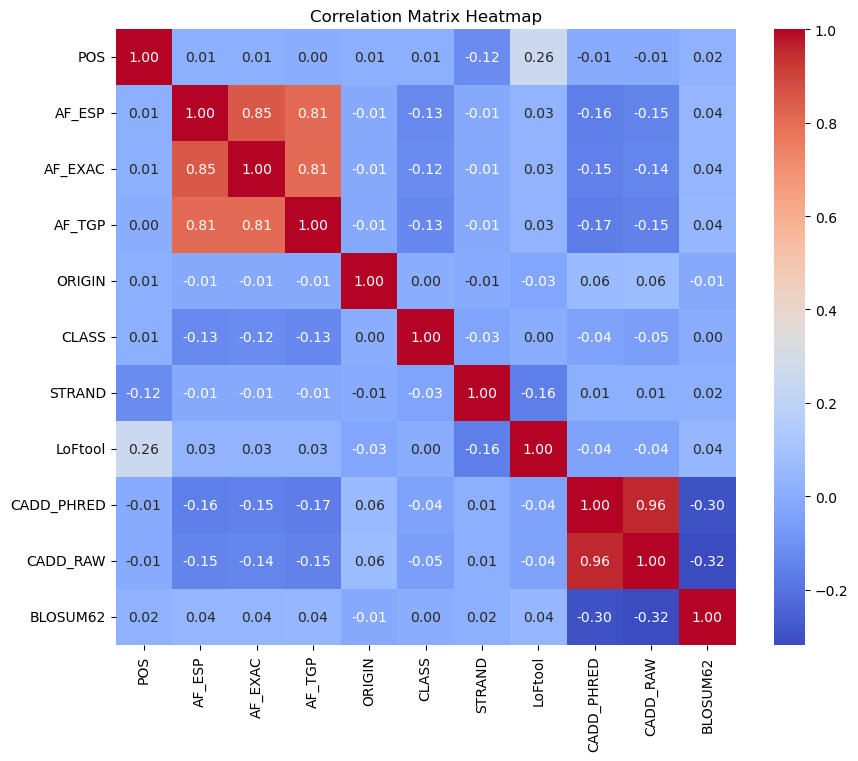

In [11]:
# filter numerical columns and create correlation heat matrix map
numerical_columns = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numerical_columns.corr() # calculate correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f') 
plt.title('Correlation Matrix Heatmap')
plt.show()

In [12]:
df.head()

CHROM      POS REF ALT  AF_ESP  AF_EXAC  AF_TGP  \
0     1  1168180   G   C  0.0771  0.10020  0.1066   
1     1  1470752   G   A  0.0000  0.00000  0.0000   
2     1  1737942   A   G  0.0000  0.00001  0.0000   
3     1  2160305   G   A  0.0000  0.00000  0.0000   
4     1  2160305   G   T  0.0000  0.00000  0.0000   

                                            CLNDISDB  \
0                                    MedGen:CN169374   
1  MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...   
2  Human_Phenotype_Ontology:HP:0000486,MedGen:C00...   
3  MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...   
4     MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002   

                                               CLNDN  \
0                                      not_specified   
1             Spinocerebellar_ataxia_21|not_provided   
2  Strabismus|Nystagmus|Hypothyroidism|Intellectu...   
3          Shprintzen-Goldberg_syndrome|not_provided   
4                       Shprintzen-Goldberg_syndrome   

                     CLNHGVS  ... Amino_acids   Codons STRAND  BAM_EDIT  \
0  NC_000001.10:g.1168180G>C  ...         E/D  gaG/gaC    1.0       NaN   
1  NC_000001.10:g.1470752G>A  ...         P/L  cCg/cTg   -1.0        OK   
2  NC_000001.10:g.1737942A>G  ...         I/T  aTc/aCc   -1.0        OK   
3  NC_000001.10:g.2160305G>A  ...         G/S  Ggc/Agc    1.0       NaN   
4  NC_000001.10:g.2160305G>T  ...         G/C  Ggc/Tgc    1.0       NaN   

                         SIFT           PolyPhen LoFtool CADD_PHRED  CADD_RAW  \
0                   tolerated             benign     NaN      1.053 -0.208682   
1  deleterious_low_confidence             benign     NaN     31.000  6.517838   
2                 deleterious  probably_damaging     NaN     28.100  6.061752   
3                         NaN                NaN     NaN     22.500  3.114491   
4                         NaN                NaN     NaN     24.700  4.766224   

  BLOSUM62  
0      2.0  
1     -3.0  
2     -1.0  
3      NaN  
4     -3.0  

[5 rows x 37 columns]

With respect to this project and experiment, there are several columns amongst the main 'df' dataframe that can be dropped.

1. BAM_EDIT = Binary Map Alignment, indicates whether it's stored in a particular database, not relevant.
2. INTRON = severely low amount of non-null values, contains date
3. EXON = contains dates, not performing time series, not relevant
4. CLNDISB = Provides MedGen database identifiers, not relevant
5. CLNHGVS = provides database identifier, not relevant
6. MC = repeat of Consequence with additional database identifier
7. CLNVI = lab location identifier, not relevant for current project.
8. SYMBOL = another identifier, redundant
9. Feature: Value included in consequence column
10. Feature_type: Value included in consequence column
11. BIOTYPE: Value included in consequence column
12. CADD_RAW: directly related to CADD_PHRED - only CADD_PHRED is needed with respect to genetic mutations, it uses a scale that is easier to work with.

In [13]:
df.drop(['BAM_EDIT', 'EXON', 'CLNDISDB', 'CLNHGVS', 
         'MC', 'CLNVI', 'SYMBOL', 'Feature', 'Feature_type', 
         'BIOTYPE', 'INTRON', 'CADD_RAW'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  object 
 8   CLNVC             65188 non-null  object 
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  object 
 12  Consequence       65188 non-null  object 
 13  IMPACT            65188 non-null  object 
 14  cDNA_position     56304 non-null  object 
 15  CDS_position      55233 non-null  object 
 16  Protein_position  55233 non-null  object

In [14]:
numerical_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   POS         65188 non-null  int64  
 1   AF_ESP      65188 non-null  float64
 2   AF_EXAC     65188 non-null  float64
 3   AF_TGP      65188 non-null  float64
 4   ORIGIN      65188 non-null  int64  
 5   CLASS       65188 non-null  int64  
 6   STRAND      65174 non-null  float64
 7   LoFtool     60975 non-null  float64
 8   CADD_PHRED  64096 non-null  float64
 9   CADD_RAW    64096 non-null  float64
 10  BLOSUM62    25593 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 5.5 MB


In [15]:
numerical_columns.head()

POS  AF_ESP  AF_EXAC  AF_TGP  ORIGIN  CLASS  STRAND  LoFtool  \
0  1168180  0.0771  0.10020  0.1066       1      0     1.0      NaN   
1  1470752  0.0000  0.00000  0.0000       1      0    -1.0      NaN   
2  1737942  0.0000  0.00001  0.0000      35      1    -1.0      NaN   
3  2160305  0.0000  0.00000  0.0000      33      0     1.0      NaN   
4  2160305  0.0000  0.00000  0.0000      33      0     1.0      NaN   

   CADD_PHRED  CADD_RAW  BLOSUM62  
0       1.053 -0.208682       2.0  
1      31.000  6.517838      -3.0  
2      28.100  6.061752      -1.0  
3      22.500  3.114491       NaN  
4      24.700  4.766224      -3.0

In [16]:
object_cols = df.select_dtypes(include=['object'])
object_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CHROM             65188 non-null  object
 1   REF               65188 non-null  object
 2   ALT               65188 non-null  object
 3   CLNDN             65188 non-null  object
 4   CLNVC             65188 non-null  object
 5   Allele            65188 non-null  object
 6   Consequence       65188 non-null  object
 7   IMPACT            65188 non-null  object
 8   cDNA_position     56304 non-null  object
 9   CDS_position      55233 non-null  object
 10  Protein_position  55233 non-null  object
 11  Amino_acids       55184 non-null  object
 12  Codons            55184 non-null  object
 13  SIFT              24836 non-null  object
 14  PolyPhen          24796 non-null  object
dtypes: object(15)
memory usage: 7.5+ MB


In [17]:
object_cols.head()

CHROM REF ALT                                              CLNDN  \
0     1   G   C                                      not_specified   
1     1   G   A             Spinocerebellar_ataxia_21|not_provided   
2     1   A   G  Strabismus|Nystagmus|Hypothyroidism|Intellectu...   
3     1   G   A          Shprintzen-Goldberg_syndrome|not_provided   
4     1   G   T                       Shprintzen-Goldberg_syndrome   

                       CLNVC Allele       Consequence    IMPACT cDNA_position  \
0  single_nucleotide_variant      C  missense_variant  MODERATE           552   
1  single_nucleotide_variant      A  missense_variant  MODERATE           523   
2  single_nucleotide_variant      G  missense_variant  MODERATE           632   
3  single_nucleotide_variant      A  missense_variant  MODERATE           132   
4  single_nucleotide_variant      T  missense_variant  MODERATE           132   

  CDS_position Protein_position Amino_acids   Codons  \
0          522              174         E/D  gaG/gaC   
1          509              170         P/L  cCg/cTg   
2          239               80         I/T  aTc/aCc   
3          100               34         G/S  Ggc/Agc   
4          100               34         G/C  Ggc/Tgc   

                         SIFT           PolyPhen  
0                   tolerated             benign  
1  deleterious_low_confidence             benign  
2                 deleterious  probably_damaging  
3                         NaN                NaN  
4                         NaN                NaN

The object and numerical columns have been separated for initial visualization. There still appear to be some errors so we will handle such as necessary.

In [18]:
# Create an empty DataFrame to store the columns with missing values
still_missing = pd.DataFrame()

# Iterate over the columns of the DataFrame and isolate missing columns
for column in df.columns:
    if df[column].isnull().any():
        still_missing[column] = df[column]

print("Columns with missing values:")
still_missing.info()


Columns with missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cDNA_position     56304 non-null  object 
 1   CDS_position      55233 non-null  object 
 2   Protein_position  55233 non-null  object 
 3   Amino_acids       55184 non-null  object 
 4   Codons            55184 non-null  object 
 5   STRAND            65174 non-null  float64
 6   SIFT              24836 non-null  object 
 7   PolyPhen          24796 non-null  object 
 8   LoFtool           60975 non-null  float64
 9   CADD_PHRED        64096 non-null  float64
 10  BLOSUM62          25593 non-null  float64
dtypes: float64(4), object(7)
memory usage: 5.5+ MB


In [19]:
still_missing.nunique()

cDNA_position       13970
CDS_position        13663
Protein_position     7339
Amino_acids          1262
Codons               2220
STRAND                  2
SIFT                    4
PolyPhen                4
LoFtool              1195
CADD_PHRED           9324
BLOSUM62                6
dtype: int64

In [20]:
for column in still_missing.columns:
    if column == 'BLOSUM62':
        # Fill missing values in the 'BLOSUM62' column with forward fill (ffill)
        still_missing[column] = still_missing[column].fillna(method='ffill')
    elif still_missing[column].dtype == 'object':
        # Fill missing values in object columns with forward fill (ffill)
        still_missing[column] = still_missing[column].fillna(method='ffill')
    elif still_missing[column].dtype == 'float64':
        # Interpolate missing values in float64 columns
        still_missing[column] = still_missing[column].interpolate()

# Fill missing values in 'LoFtool' column with 0
still_missing['LoFtool'] = still_missing['LoFtool'].fillna(0)

# Check the updated DataFrame information
still_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cDNA_position     65188 non-null  object 
 1   CDS_position      65188 non-null  object 
 2   Protein_position  65188 non-null  object 
 3   Amino_acids       65188 non-null  object 
 4   Codons            65188 non-null  object 
 5   STRAND            65188 non-null  float64
 6   SIFT              65188 non-null  object 
 7   PolyPhen          65188 non-null  object 
 8   LoFtool           65188 non-null  float64
 9   CADD_PHRED        65188 non-null  float64
 10  BLOSUM62          65188 non-null  float64
dtypes: float64(4), object(7)
memory usage: 5.5+ MB


In [21]:
df.update(still_missing)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  object 
 8   CLNVC             65188 non-null  object 
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  object 
 12  Consequence       65188 non-null  object 
 13  IMPACT            65188 non-null  object 
 14  cDNA_position     65188 non-null  object 
 15  CDS_position      65188 non-null  object 
 16  Protein_position  65188 non-null  object

In [22]:
df_original = df.copy()

All null values have been filled in the dataframe. The next step in cleaning is to visualize outliers and distributions. To do this, we must convert the object columns to numeric first.

In [23]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Iterate over each column in the dataframe
for column in df.columns:
    # Check if the column's dtype is 'object'
    if df[column].dtype == 'object':
        # Apply label encoding to the column
        df[column] = label_encoder.fit_transform(df[column])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  int32  
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  int32  
 3   ALT               65188 non-null  int32  
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  int32  
 8   CLNVC             65188 non-null  int32  
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  int32  
 12  Consequence       65188 non-null  int32  
 13  IMPACT            65188 non-null  int32  
 14  cDNA_position     65188 non-null  int32  
 15  CDS_position      65188 non-null  int32  
 16  Protein_position  65188 non-null  int32 

In [24]:
# Iterate through columns
for column in df.columns:
    # Check if the column has 'int32' data type
    if df[column].dtype == 'int32':
        # Change 'int32' to 'int64'
        df[column] = df[column].astype('int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  int64  
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  int64  
 3   ALT               65188 non-null  int64  
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  int64  
 8   CLNVC             65188 non-null  int64  
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  int64  
 12  Consequence       65188 non-null  int64  
 13  IMPACT            65188 non-null  int64  
 14  cDNA_position     65188 non-null  int64  
 15  CDS_position      65188 non-null  int64  
 16  Protein_position  65188 non-null  int64 

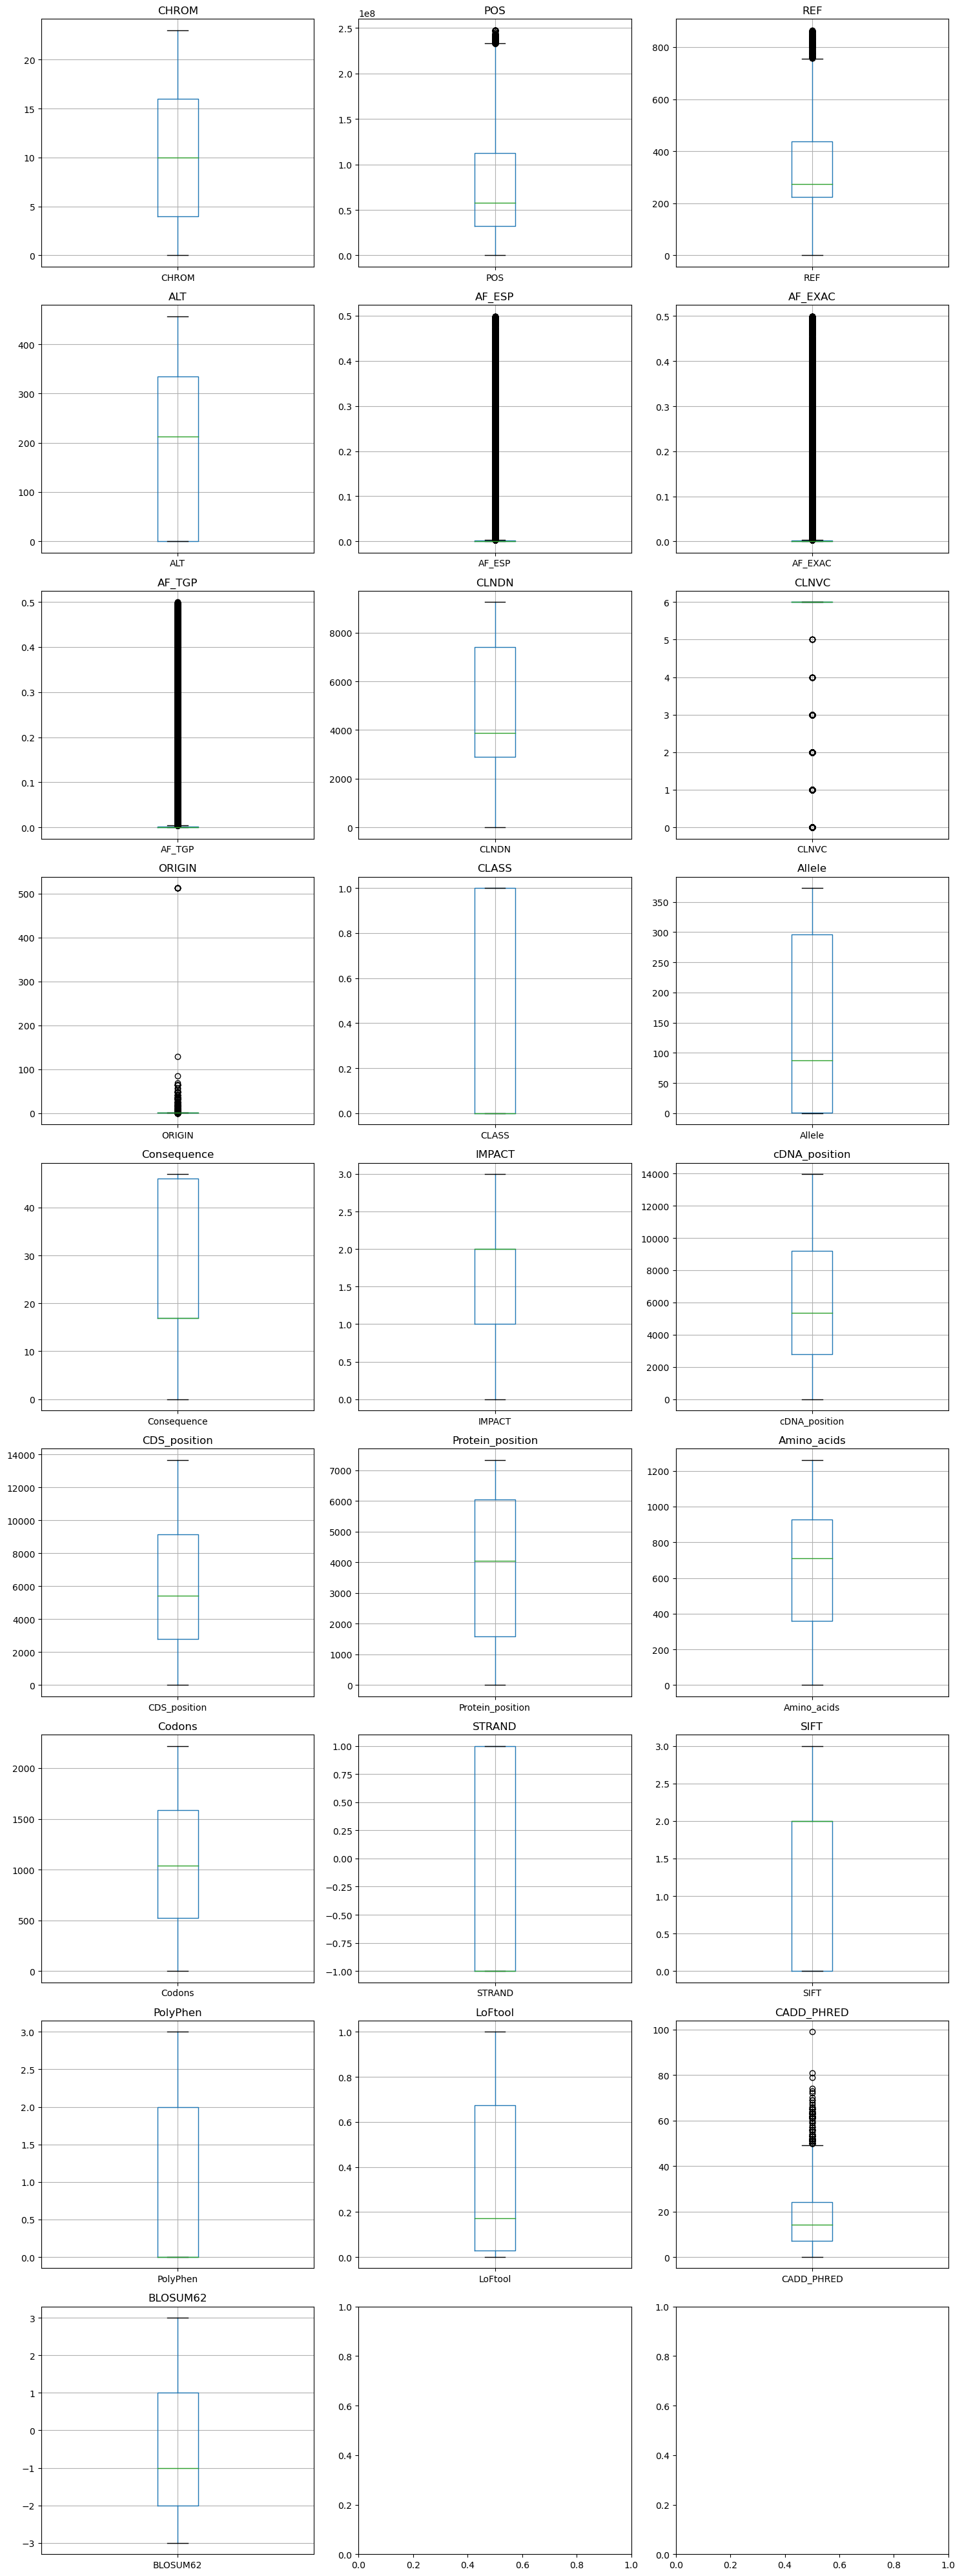

In [25]:
# Calculate the number of rows and columns for subplots
num_columns = 3
num_rows = (len(df.columns) - 1) // num_columns + 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 40))

# Iterate through columns and plot boxplots
for i, column in enumerate(df.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row][col]
    df.boxplot(column=column, ax=ax)
    ax.set_title(column)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


A few of the boxplots above show significant outliers in a few of the columns. There are three columns in particular that look especially bad - the allele frequency columns (AF_ESP, AF_EXAC, AF_TGP). For my particular project, these columns are very important. To recall the correlation heat map, these columns have high correlations with each other AND other variables. This means they could either be detrimental or essential to our model.

These allele frequency measures are useful in population genetics and genomic research to understand the prevalence and distribution of genetic variants in different populations. They can help researchers assess the potential impact of specific variants on health, disease susceptibility, and genetic diversity. What's interesting is these variables are theoretically supposed to be the same as they represent the same value. However, the value was calculated from a different source for each column.

1. AF_ESP (Allele Frequency in the NHLBI Exome Sequencing Project) provides allele frequency data based on the NHLBI project that sequenced the exomes of individuals to study genetic diseases.
2. AF_EXAC (Allele Frequency in the Exome Aggregation Consortium) is a database that aggregates allele frequency data from large-scale sequencing projects, such as ExAC, to understand genetic variation.
3. AF_TGP (Allele Frequency in the 1000 Genomes Project) represents allele frequency information from the 1000 Genomes Project, which aimed to create a catalog of genetic variations in human populations by sequencing thousands of individuals.


# Data Exploratory Analysis

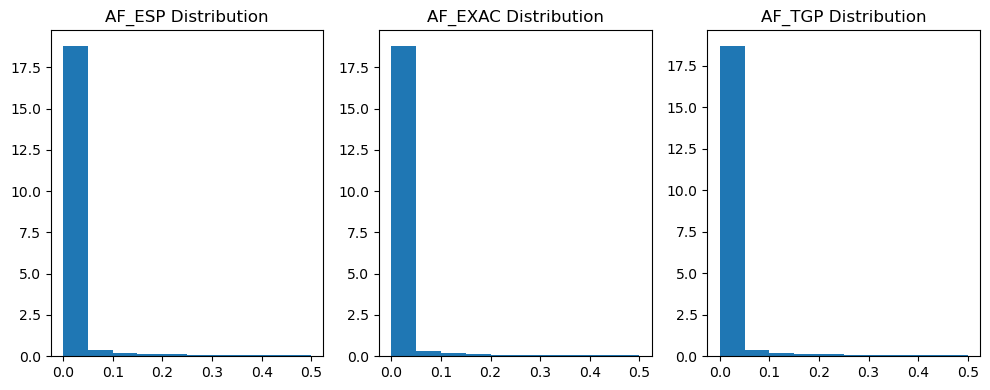

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 4))

# Plot histograms for each column

ax1.hist(df['AF_ESP'], bins=10, density=True)
ax1.set_title('AF_ESP Distribution')


ax2.hist(df['AF_EXAC'], bins=10, density=True)
ax2.set_title('AF_EXAC Distribution')


ax3.hist(df['AF_TGP'], bins=10, density=True)
ax3.set_title('AF_TGP Distribution')

plt.tight_layout()

plt.show()

The distributions of Allele frequency above appear to look similar and also heavily skewed to the right. Combining that with the 0% missing values and high correlation for all three enhance the argument that the columns are not significiantly different.

However...

One key piece of information has yet to be dealt with. The columns look the same and have 0% missing values, but with regards to the original database, missing values in these columns are labeled as "0". Thus, python will count these values as non-null instead of null when iterating through the column. 

Let's further explore the actual missing values in the columns that are labeled as "0".

In [27]:
allele_df = df[['AF_ESP', 'AF_EXAC', 'AF_TGP']]

allele_df.info()

# initiate count of three new variables

esp_zeros = 0
exac_zeros = 0
tgp_zeros = 0

# iterate through allele_df and print count of zeroes 

for column in allele_df.columns:
    column_values = allele_df[column].values
    zeros_count = len(column_values[column_values == 0])
    
    if column == 'AF_ESP':
        esp_zeros += zeros_count
    elif column == 'AF_EXAC':
        exac_zeros += zeros_count
    elif column == 'AF_TGP':
        tgp_zeros += zeros_count

print("Count of zeroes (missing values) in AF_ESP column:", esp_zeros)
print("Count of zeroes (missing values) in AF_EXAC column:", exac_zeros)
print("Count of zeroes (missing values) in AF_TGP column:", tgp_zeros)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AF_ESP   65188 non-null  float64
 1   AF_EXAC  65188 non-null  float64
 2   AF_TGP   65188 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB
Count of zeroes (missing values) in AF_ESP column: 35781
Count of zeroes (missing values) in AF_EXAC column: 24047
Count of zeroes (missing values) in AF_TGP column: 37972


In [28]:
esp_missing = round((esp_zeros / len(allele_df)) * 100, 2)
exac_missing = round((exac_zeros / len(allele_df)) * 100, 2)
tgp_missing = round((tgp_zeros / len(allele_df)) * 100, 2)

print("Percentage of actual missing values in AF_ESP column:", esp_missing)
print("Percentage of actual missing values in AF_EXAC column:", exac_missing)
print("Percentage of actual missing values in AF_TGP column:", tgp_missing)

Percentage of actual missing values in AF_ESP column: 54.89
Percentage of actual missing values in AF_EXAC column: 36.89
Percentage of actual missing values in AF_TGP column: 58.25


All three columns appear to have different counts of zero. Thus, they have different counts of actual null values. 

ESP and TGP have similar missing percentages at 54.89 and 58.25, respectively. EXAC, however, has only 36.89 % missing. This seems to be much less, so it's possible the EXAC column is more comprehensive with respect to allele frequency data collection. As a scientist though, it's important to remember that just because something appears to be different doesn't mean it's significant. Hence, association is not synonymous with causation. 

The next step is to visualize the distributions after removing null-values.

In [29]:
for column in allele_df.columns:
    allele_df.loc[allele_df[column] == 0, column] = None

allele_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AF_ESP   29407 non-null  float64
 1   AF_EXAC  41141 non-null  float64
 2   AF_TGP   27216 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB


The 'allele_df' dataframe above now has the correct count of non-null values in each column.

In [30]:
# Define the methods for filling null values
methods = ['mean', 'median', 'interpolation']

# Calculate skewness and kurtosis for original DataFrame
original_skewness = allele_df.skew()
original_kurtosis = allele_df.kurtosis()

# Create a dictionary to store the results
results = {}

# Iterate over the methods
for method in methods:
    # Fill null values using the respective method
    if method == 'mean':
        filled_df = allele_df.fillna(allele_df.mean())
    elif method == 'median':
        filled_df = allele_df.fillna(allele_df.median())
    elif method == 'interpolation':
        filled_df = allele_df.interpolate()
    
    # Calculate skewness and kurtosis
    skewness = filled_df.skew()
    kurtosis = filled_df.kurtosis()
    
    # Store the results in the dictionary
    results[method] = {'skewness': skewness, 'kurtosis': kurtosis}

# Print the results
for method in methods:
    print(f"DataFrame with {method.capitalize()}-Filled Null Values:")
    print("Skewness:\n", results[method]['skewness'])
    print("Kurtosis:\n", results[method]['kurtosis'])
    print()


DataFrame with Mean-Filled Null Values:
Skewness:
 AF_ESP     5.202084
AF_EXAC    5.298650
AF_TGP     5.019229
dtype: float64
Kurtosis:
 AF_ESP     30.898066
AF_EXAC    30.640676
AF_TGP     29.132435
dtype: float64

DataFrame with Median-Filled Null Values:
Skewness:
 AF_ESP     5.487124
AF_EXAC    5.438034
AF_TGP     5.360450
dtype: float64
Kurtosis:
 AF_ESP     32.284693
AF_EXAC    31.367908
AF_TGP     30.756773
dtype: float64

DataFrame with Interpolation-Filled Null Values:
Skewness:
 AF_ESP     4.116734
AF_EXAC    4.615365
AF_TGP     3.776132
dtype: float64
Kurtosis:
 AF_ESP     18.511210
AF_EXAC    22.881498
AF_TGP     15.487232
dtype: float64



The skew and kurtosis of the three types of null value filling are above. Interpolation proves to invoke the smallest skew and kurtosis on the data; thus, interpolation will be used for all three columns for the remainder of the project.

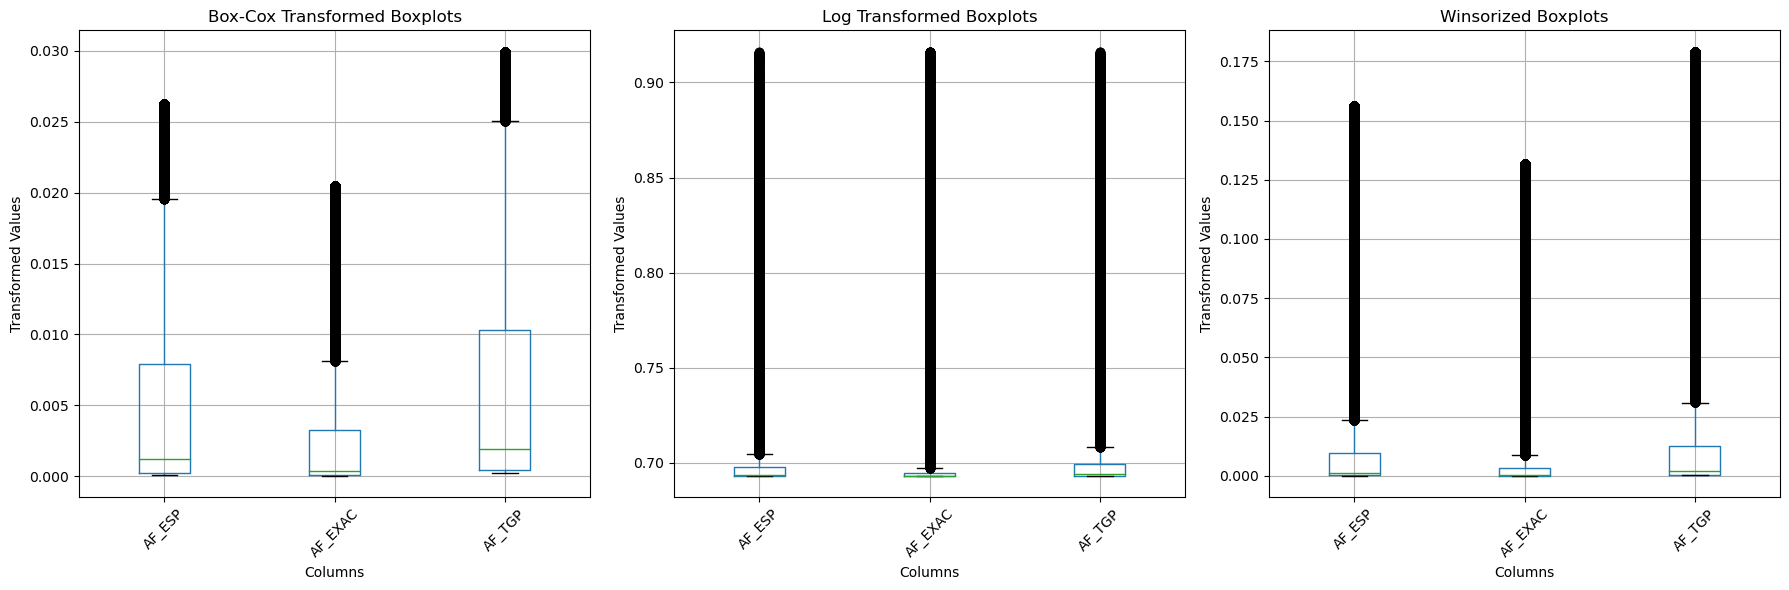

In [31]:
allele_df = allele_df.interpolate()

# Apply Box-Cox transformation to the DataFrame
allele_df_boxcox = allele_df.copy()
for column in allele_df_boxcox.columns:
    transformed_data, _ = boxcox(allele_df_boxcox[column].dropna() + 1)  # Add 1 to avoid zero values
    allele_df_boxcox[column].loc[~allele_df_boxcox[column].isna()] = transformed_data

log_constant = 1
allele_df_log = np.log1p(allele_df + log_constant)

# Apply winsorization to the DataFrame
allele_df_winsorized = allele_df.copy()
for column in allele_df_winsorized.columns:
    allele_df_winsorized[column] = winsorize(allele_df_winsorized[column].dropna(), limits=[0.05, 0.05])

# Create boxplots of transformed columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Box-Cox transformed boxplots
allele_df_boxcox.boxplot(ax=axes[0])
axes[0].set_title("Box-Cox Transformed Boxplots")
axes[0].set_xticklabels(allele_df_boxcox.columns, rotation=45)
axes[0].set_xlabel("Columns")
axes[0].set_ylabel("Transformed Values")

# Log transformed boxplots
allele_df_log.boxplot(ax=axes[1])
axes[1].set_title("Log Transformed Boxplots")
axes[1].set_xticklabels(allele_df_log.columns, rotation=45)
axes[1].set_xlabel("Columns")
axes[1].set_ylabel("Transformed Values")

# Winsorized boxplots
allele_df_winsorized.boxplot(ax=axes[2])
axes[2].set_title("Winsorized Boxplots")
axes[2].set_xticklabels(allele_df_winsorized.columns, rotation=45)
axes[2].set_xlabel("Columns")
axes[2].set_ylabel("Transformed Values")

# Adjusting the layout
plt.tight_layout()

# Display the plot
plt.show()


Box-cox transformation transforms the outliers the best in all three columns via the boxplot representations above. Let's now update our main dataframe

In [32]:
df.update(allele_df_boxcox)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  int64  
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  int64  
 3   ALT               65188 non-null  int64  
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  int64  
 8   CLNVC             65188 non-null  int64  
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  int64  
 12  Consequence       65188 non-null  int64  
 13  IMPACT            65188 non-null  int64  
 14  cDNA_position     65188 non-null  int64  
 15  CDS_position      65188 non-null  int64  
 16  Protein_position  65188 non-null  int64 

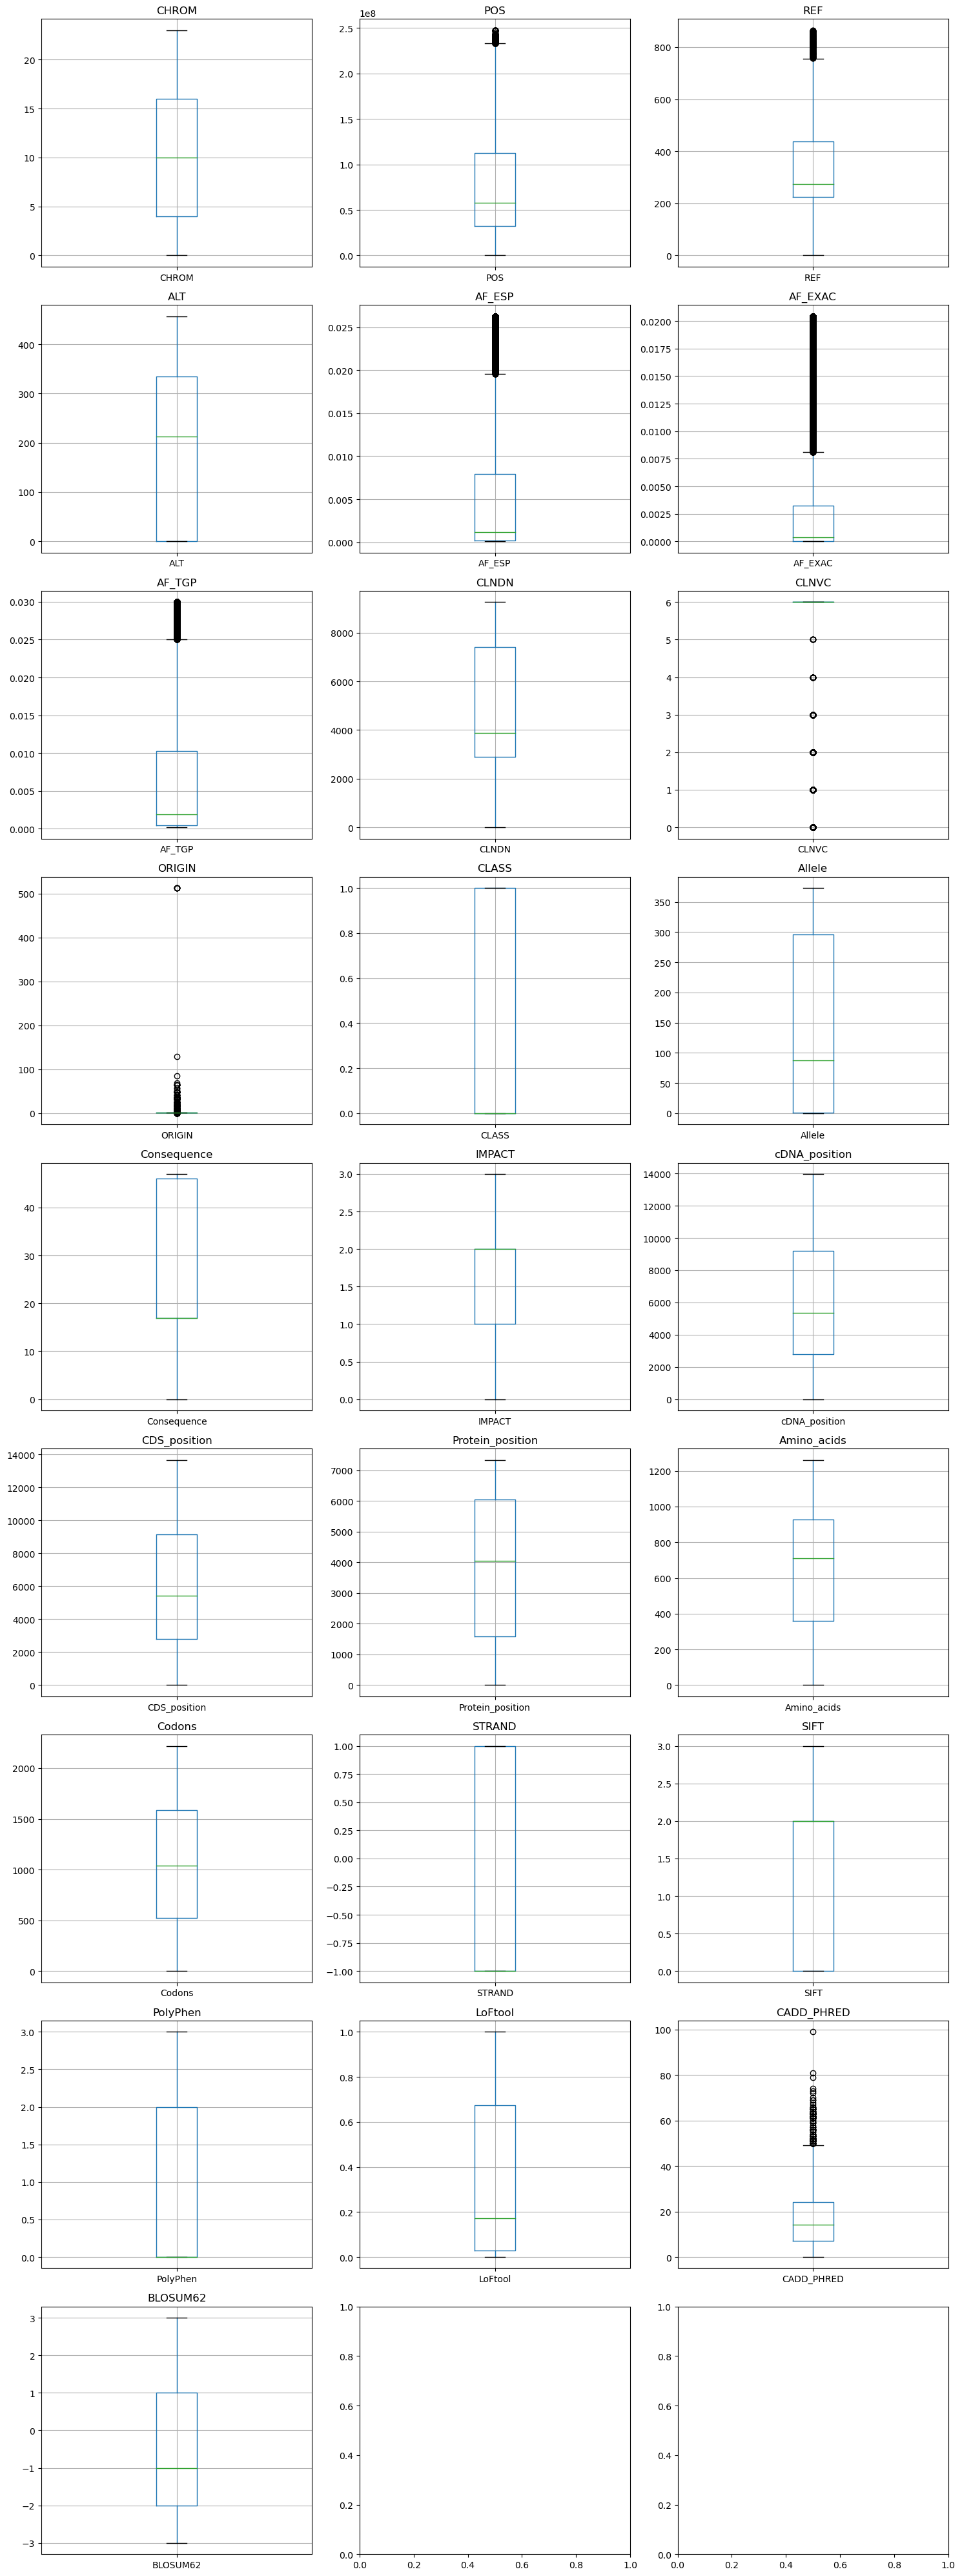

In [33]:
# Calculate the number of rows and columns for subplots
num_columns = 3
num_rows = (len(df.columns) - 1) // num_columns + 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 40))

# Iterate through columns and plot boxplots
for i, column in enumerate(df.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row][col]
    df.boxplot(column=column, ax=ax)
    ax.set_title(column)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [34]:
# Calculate z-scores for each column
z_scores = df.apply(stats.zscore)

# Identify outliers using z-score threshold
z_score_threshold = 3  # Adjust the threshold as needed

# Calculate the number of outliers for each column
num_outliers = (np.abs(z_scores) > z_score_threshold).sum()

# Print the number of outliers for each column
print("Number of Outliers:")
print(num_outliers)


Number of Outliers:
CHROM                  0
POS                    0
REF                    0
ALT                    0
AF_ESP                 0
AF_EXAC                0
AF_TGP                 0
CLNDN                  0
CLNVC               3543
ORIGIN               416
CLASS                  0
Allele                 0
Consequence            0
IMPACT                 0
cDNA_position          0
CDS_position           0
Protein_position       0
Amino_acids            0
Codons                 0
STRAND                 0
SIFT                   0
PolyPhen               0
LoFtool                0
CADD_PHRED           155
BLOSUM62               0
dtype: int64


C:\Users\Jody\AppData\Local\Temp\ipykernel_28120\3471927310.py:2: DeprecationWarning: Please use `zscore` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  z_scores = df.apply(stats.zscore)


I have successfully dealt with outliers at this point. Unfortunately, there are still 3 columns above that contain some outliers with a z-score above 3. I attempted to further transform the data in the 3 abnormal columns, but nothing seemed to deal with the outliers well. Thus, I'm choosing to leave these columns as is for now until my skill repertoire has increased.

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  int64  
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  int64  
 3   ALT               65188 non-null  int64  
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  int64  
 8   CLNVC             65188 non-null  int64  
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  int64  
 12  Consequence       65188 non-null  int64  
 13  IMPACT            65188 non-null  int64  
 14  cDNA_position     65188 non-null  int64  
 15  CDS_position      65188 non-null  int64  
 16  Protein_position  65188 non-null  int64 

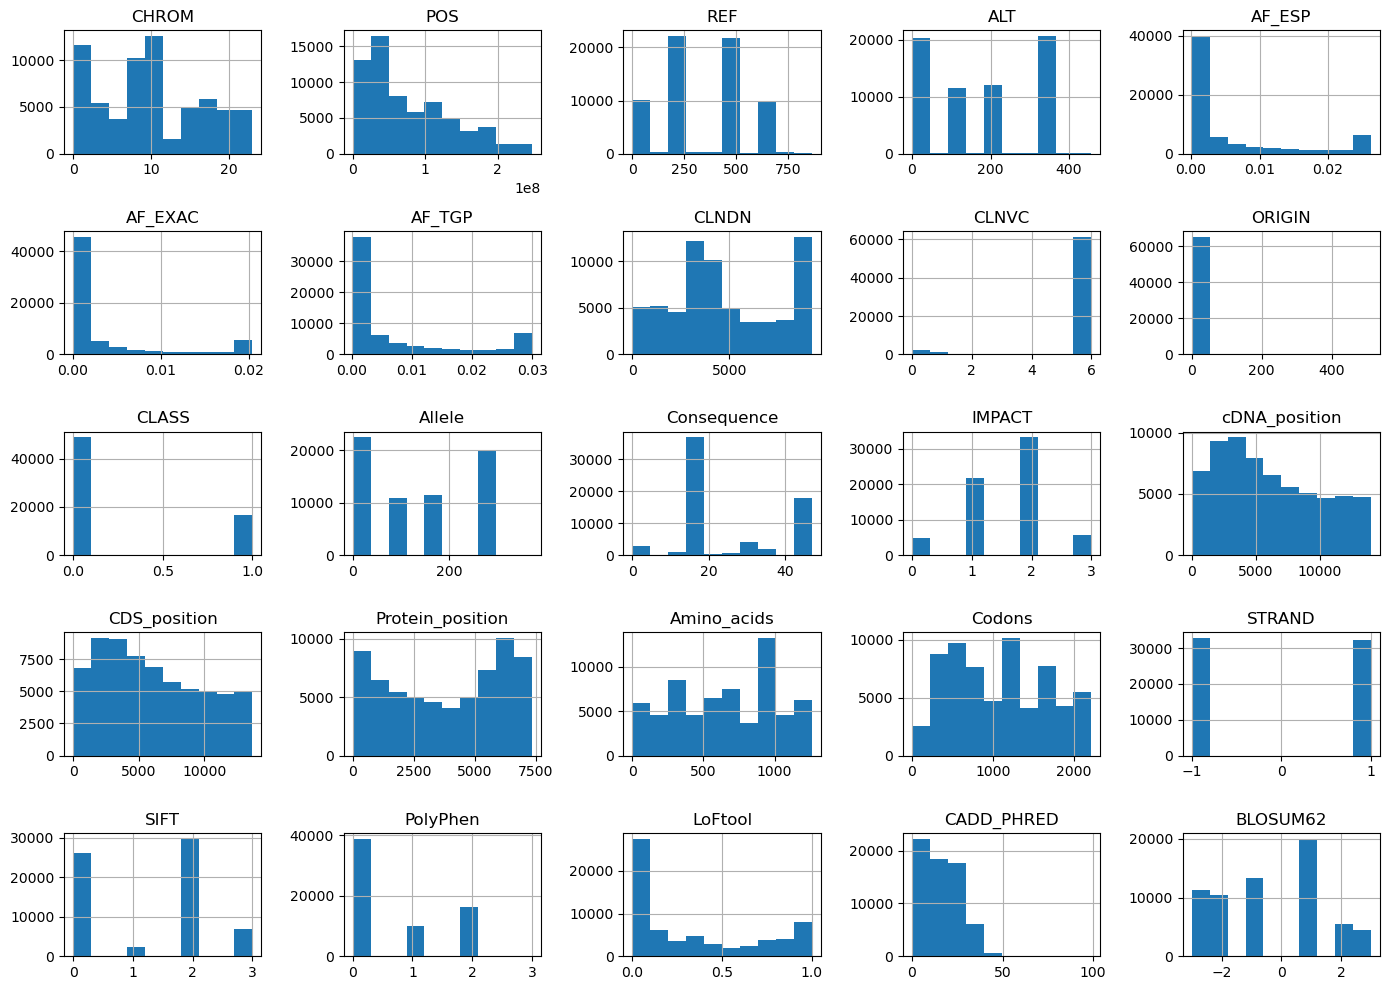

In [36]:
# Plot histograms of all columns with larger size
df.hist(figsize=(14, 10))
plt.tight_layout()
plt.show()

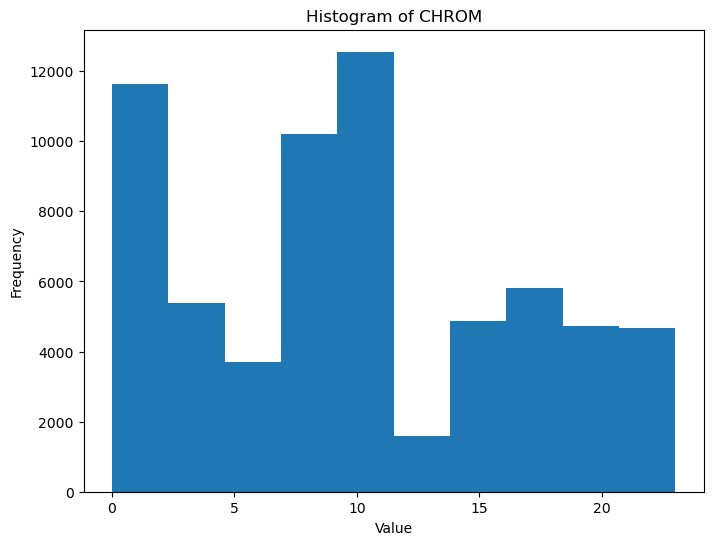

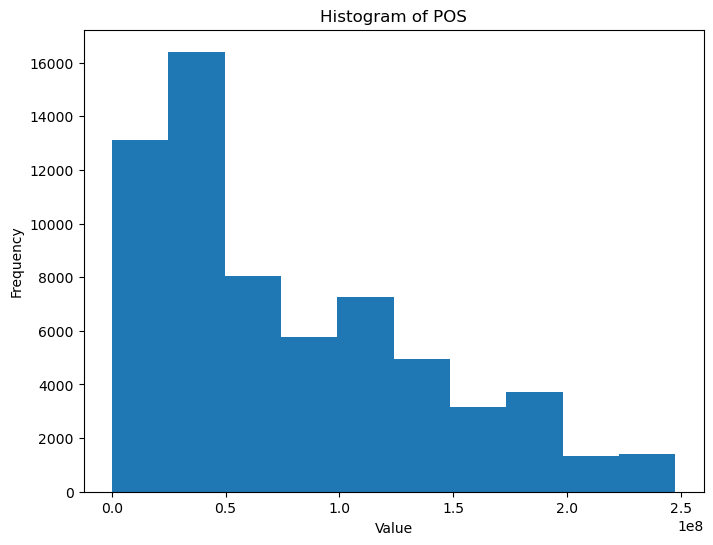

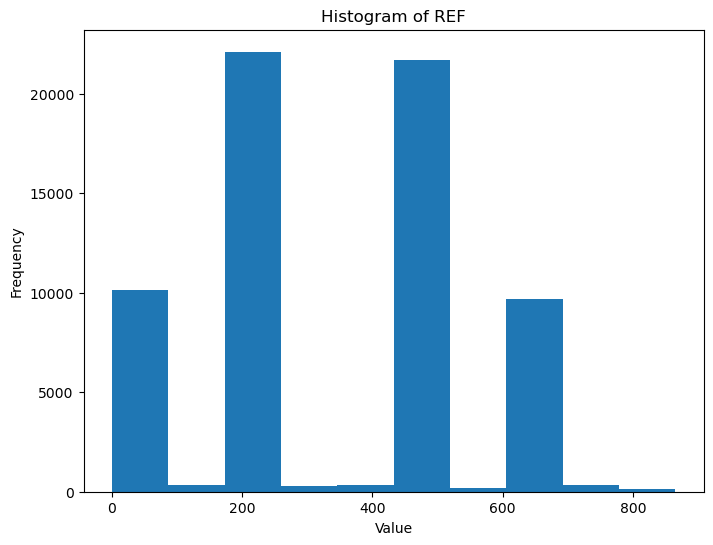

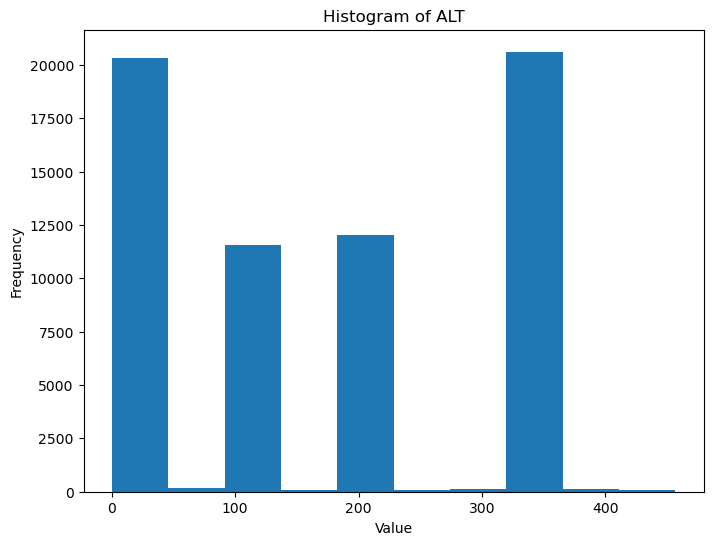

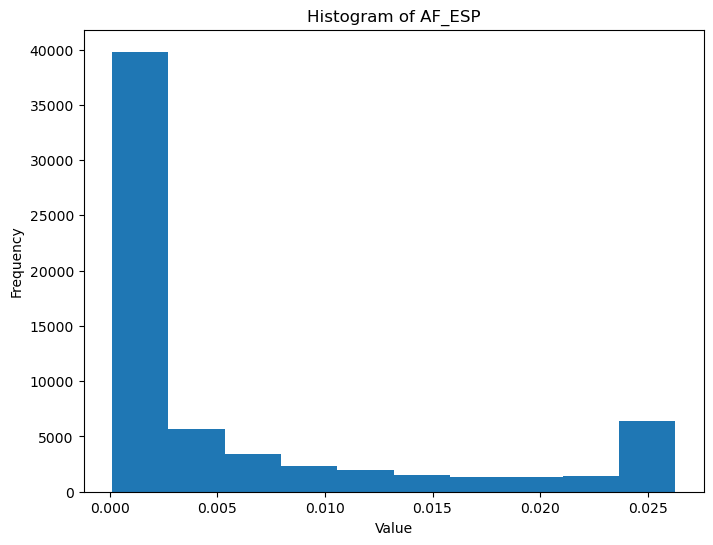

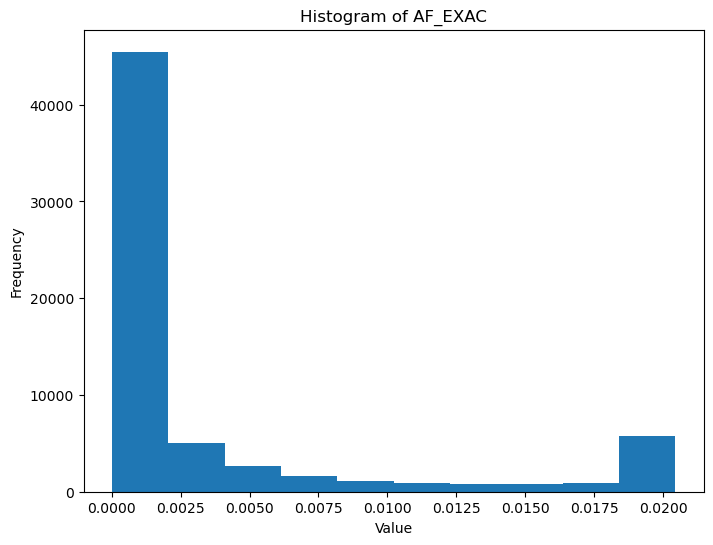

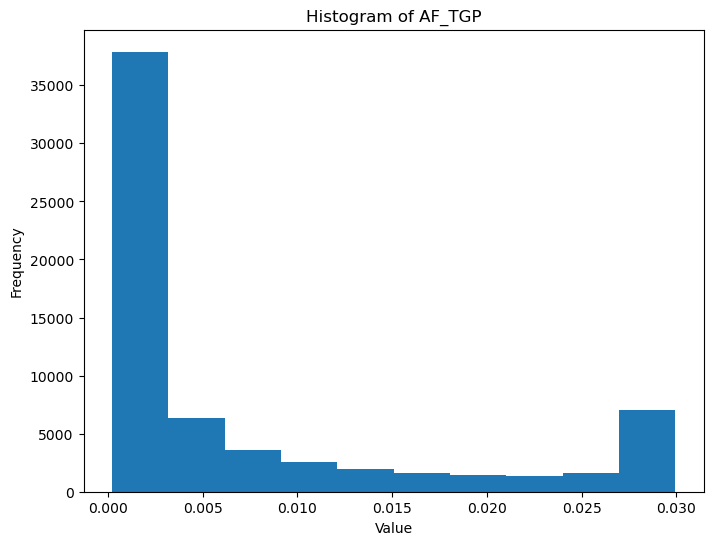

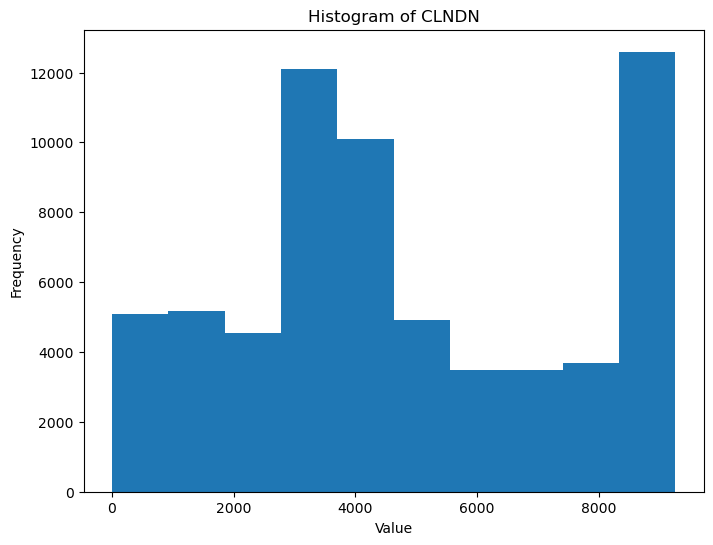

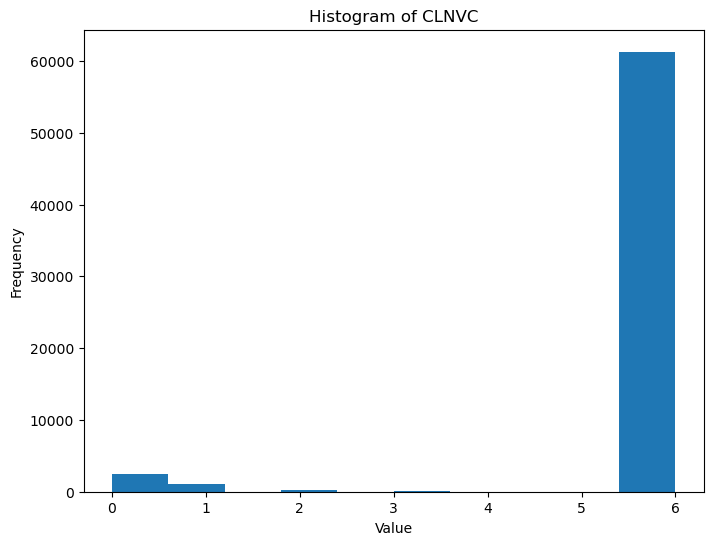

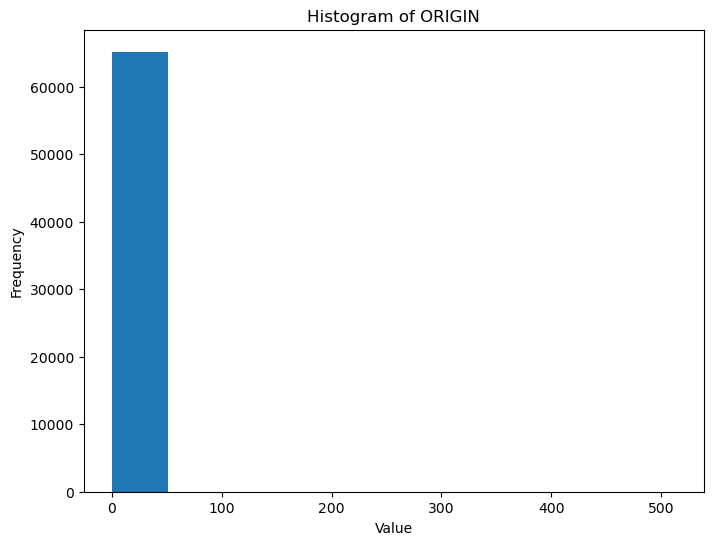

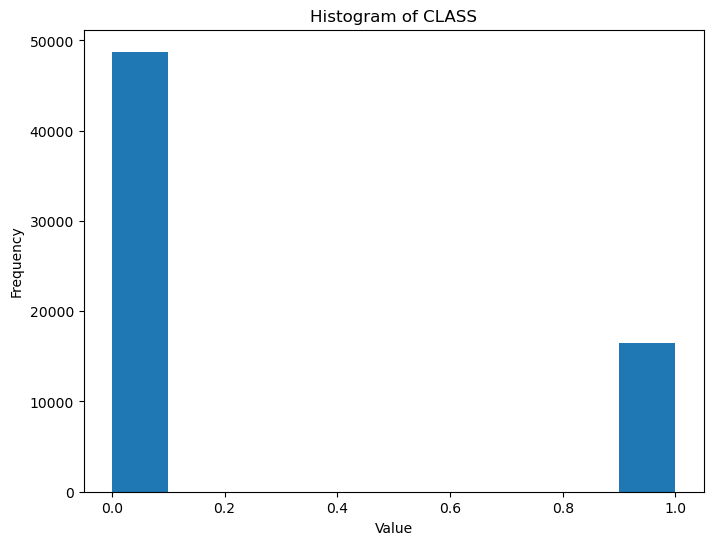

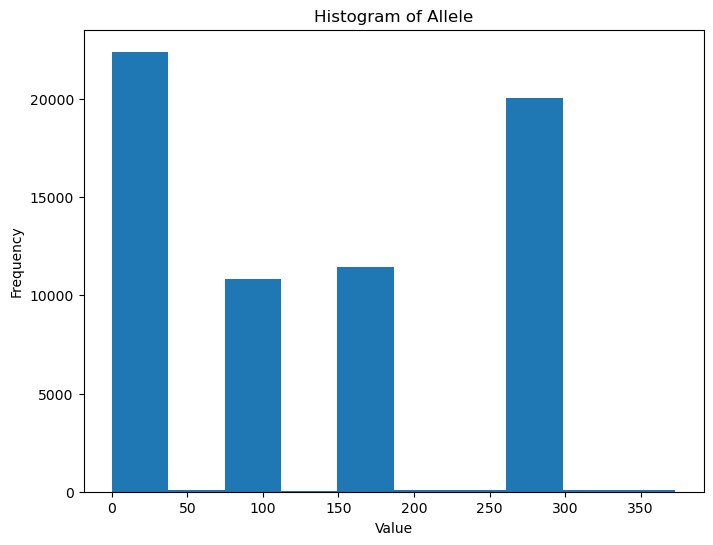

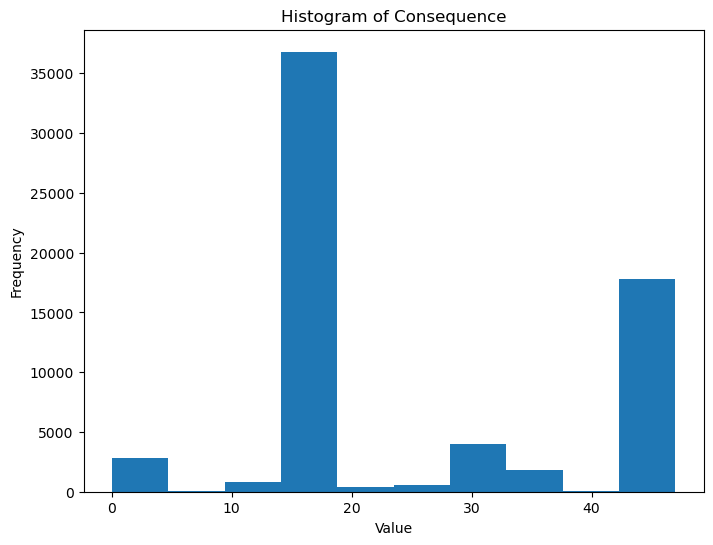

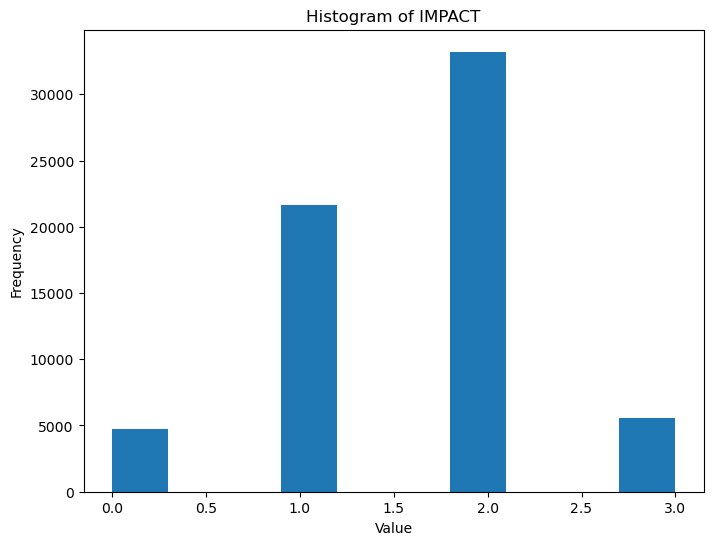

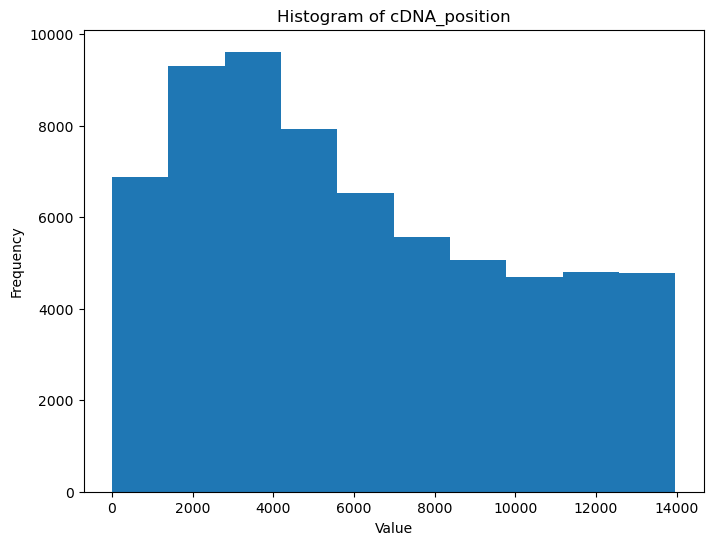

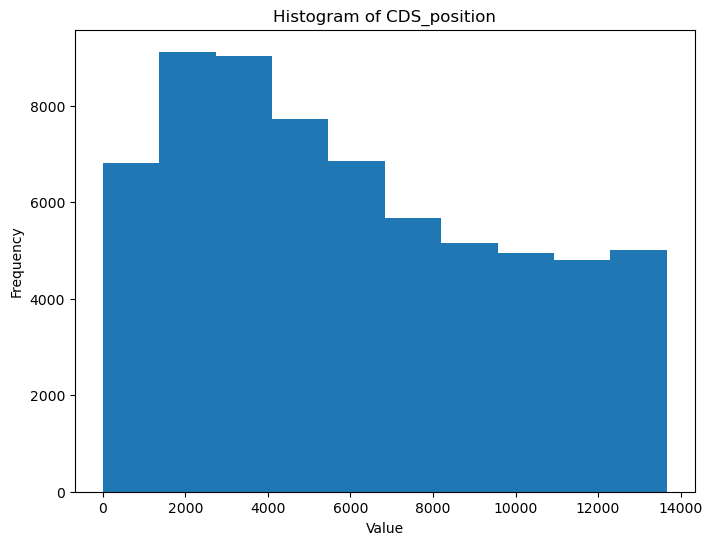

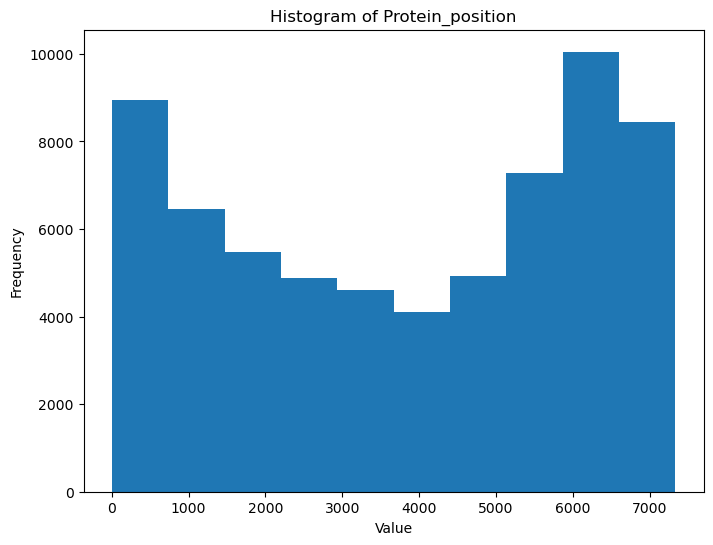

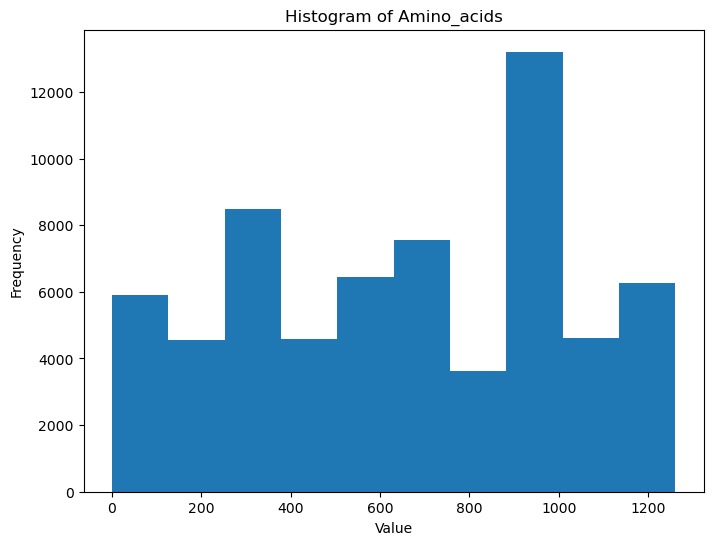

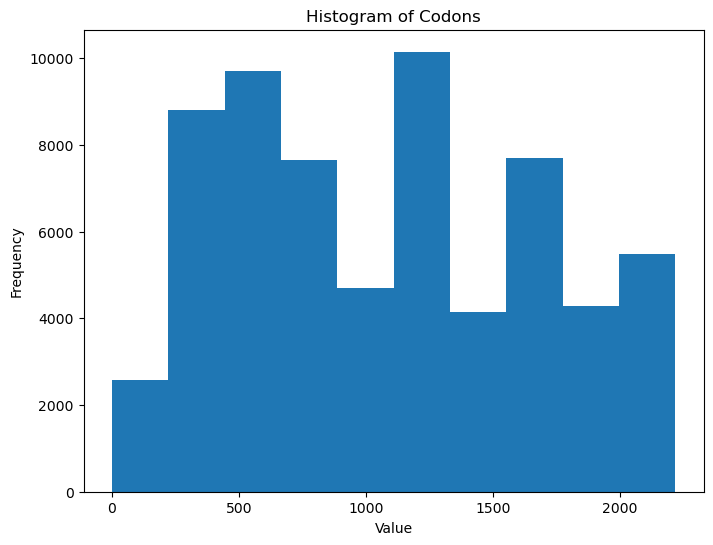

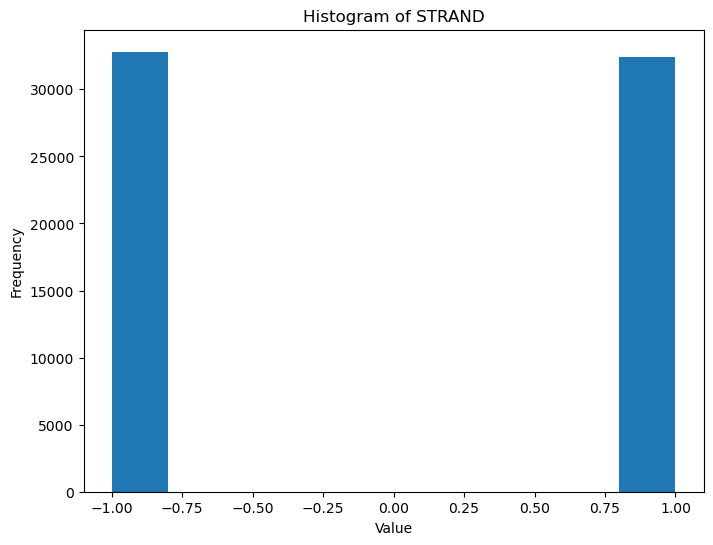

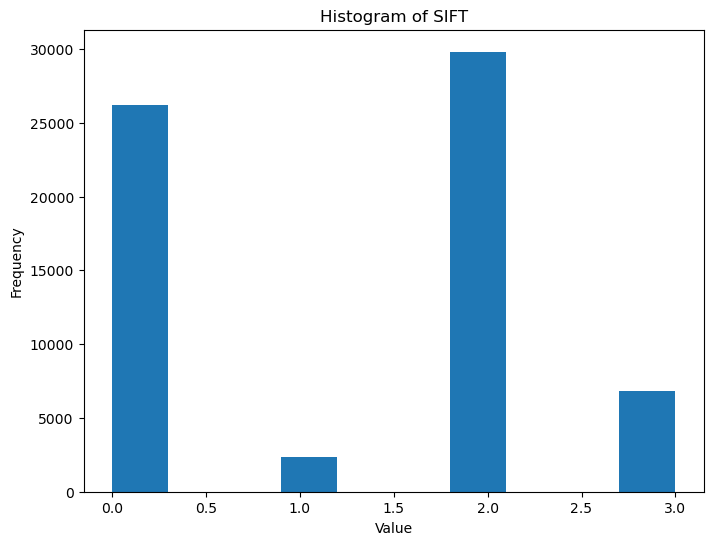

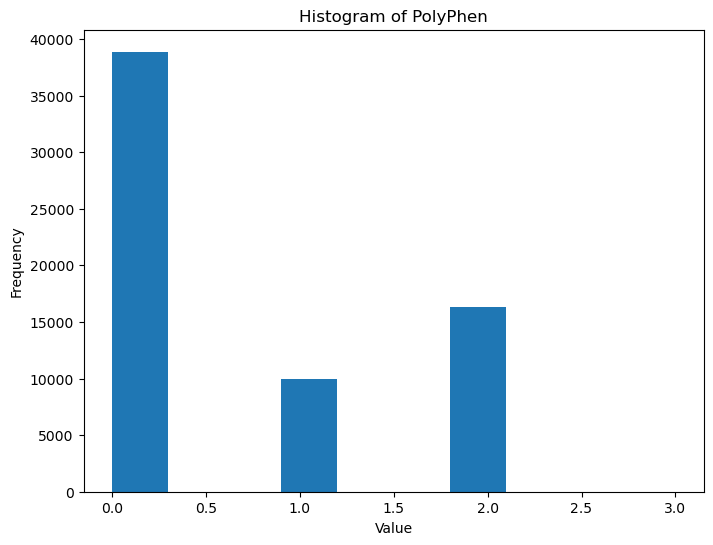

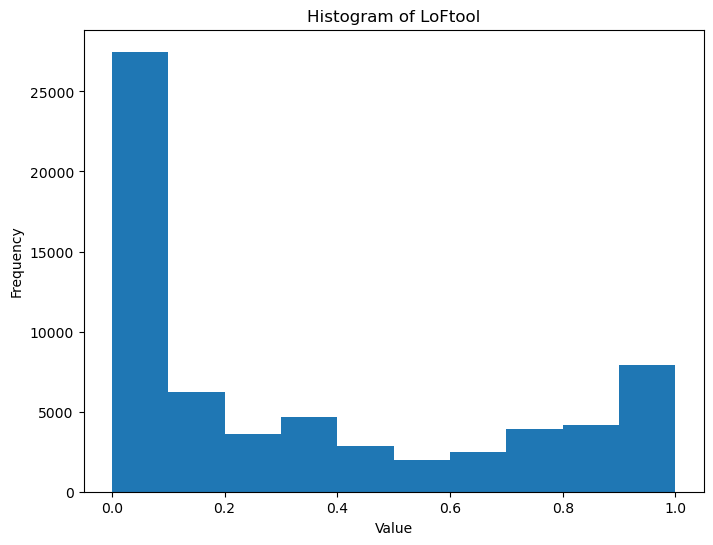

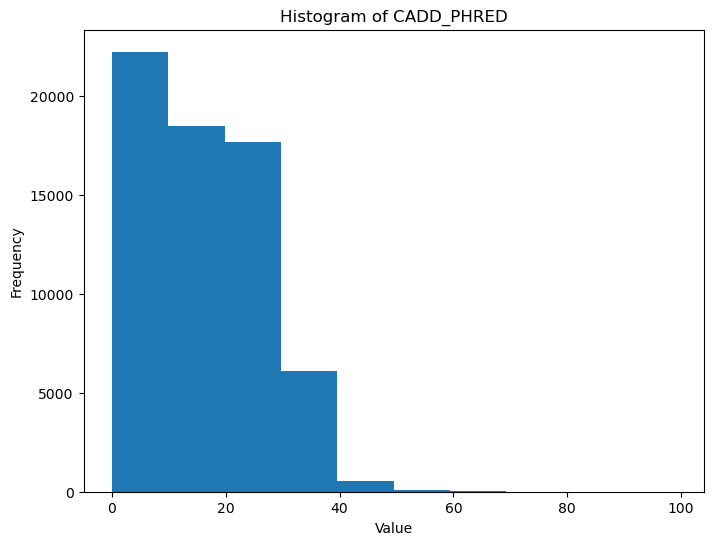

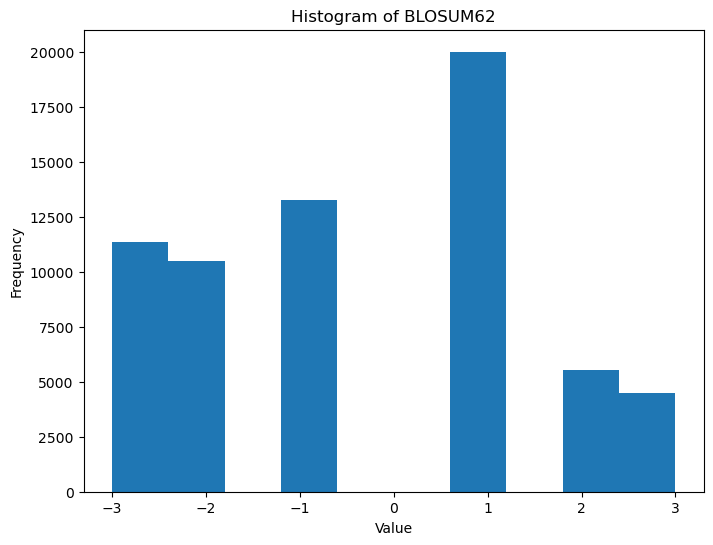

In [37]:
import matplotlib.pyplot as plt

# Iterate through columns and plot histograms
for column in df.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df[column])
    plt.title(f"Histogram of {column}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()


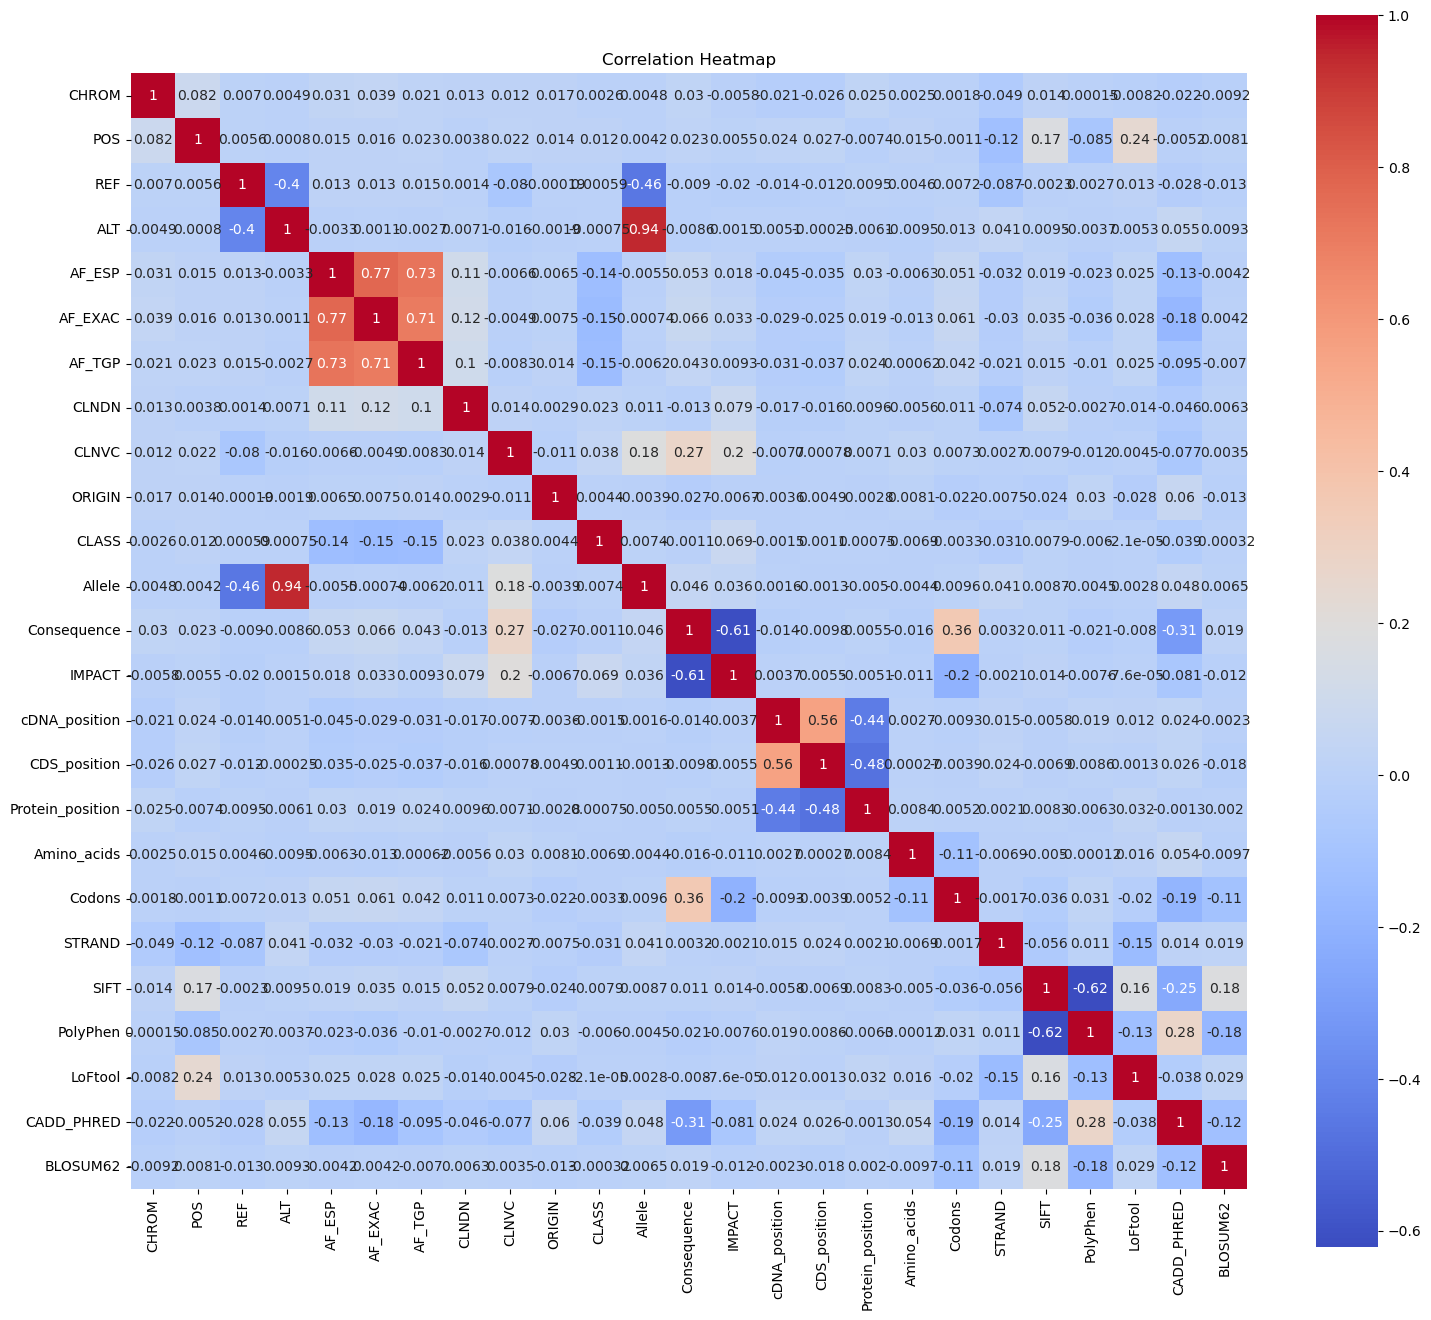

In [38]:
# Create a heatmap
plt.figure(figsize=(18, 16))

correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)

# Set the title
plt.title('Correlation Heatmap')

# Display the heatmap
plt.show()

We're beginning to understand our cleaned data much better now. The correlation heat map above shows that some variables have high correlations with each other. This can be both good and bad for the model. A target variable with high correlations with features can either mean the variables are good predictors, or there's an issue with collinearity. We'll explore that here and introduce feature engineering and feature selection into the project.

In [39]:
# Get the correlation matrix
corr_matrix = df.corr()

# Create a list to store correlation pairs
correlation_pairs = []

# Iterate through the correlation matrix
for i, column1 in enumerate(corr_matrix.columns):
    for j, column2 in enumerate(corr_matrix.columns):
        if i != j:  
            correlation = abs(corr_matrix[column1][column2])
            correlation_pairs.append((column1, column2, correlation))

# Sort correlation pairs by the absolute correlation in descending order
correlation_pairs.sort(key=lambda x: x[2], reverse=True)

# Print the sorted correlation pairs
for pair in correlation_pairs:
    column1, column2, correlation = pair
    print(f"Absolute Correlation between {column1} and {column2}: {correlation:.2f}")


Absolute Correlation between ALT and Allele: 0.94
Absolute Correlation between Allele and ALT: 0.94
Absolute Correlation between AF_ESP and AF_EXAC: 0.77
Absolute Correlation between AF_EXAC and AF_ESP: 0.77
Absolute Correlation between AF_ESP and AF_TGP: 0.73
Absolute Correlation between AF_TGP and AF_ESP: 0.73
Absolute Correlation between AF_EXAC and AF_TGP: 0.71
Absolute Correlation between AF_TGP and AF_EXAC: 0.71
Absolute Correlation between SIFT and PolyPhen: 0.62
Absolute Correlation between PolyPhen and SIFT: 0.62
Absolute Correlation between Consequence and IMPACT: 0.61
Absolute Correlation between IMPACT and Consequence: 0.61
Absolute Correlation between cDNA_position and CDS_position: 0.56
Absolute Correlation between CDS_position and cDNA_position: 0.56
Absolute Correlation between CDS_position and Protein_position: 0.48
Absolute Correlation between Protein_position and CDS_position: 0.48
Absolute Correlation between REF and Allele: 0.46
Absolute Correlation between Allele 

In [40]:
# Get the correlation matrix
corr_matrix = df.corr()

# Iterate through the correlation matrix
for column1 in corr_matrix.columns:
    for column2 in corr_matrix.columns:
        if column1 != column2:  # Exclude same-same pairs
            correlation = corr_matrix[column1][column2]
            if abs(correlation) > 0.10:
                print(f"Correlation between {column1} and {column2}: {correlation:.2f}")


Correlation between POS and STRAND: -0.12
Correlation between POS and SIFT: 0.17
Correlation between POS and LoFtool: 0.24
Correlation between REF and ALT: -0.40
Correlation between REF and Allele: -0.46
Correlation between ALT and REF: -0.40
Correlation between ALT and Allele: 0.94
Correlation between AF_ESP and AF_EXAC: 0.77
Correlation between AF_ESP and AF_TGP: 0.73
Correlation between AF_ESP and CLNDN: 0.11
Correlation between AF_ESP and CLASS: -0.14
Correlation between AF_ESP and CADD_PHRED: -0.13
Correlation between AF_EXAC and AF_ESP: 0.77
Correlation between AF_EXAC and AF_TGP: 0.71
Correlation between AF_EXAC and CLNDN: 0.12
Correlation between AF_EXAC and CLASS: -0.15
Correlation between AF_EXAC and CADD_PHRED: -0.18
Correlation between AF_TGP and AF_ESP: 0.73
Correlation between AF_TGP and AF_EXAC: 0.71
Correlation between AF_TGP and CLNDN: 0.10
Correlation between AF_TGP and CLASS: -0.15
Correlation between CLNDN and AF_ESP: 0.11
Correlation between CLNDN and AF_EXAC: 0.12

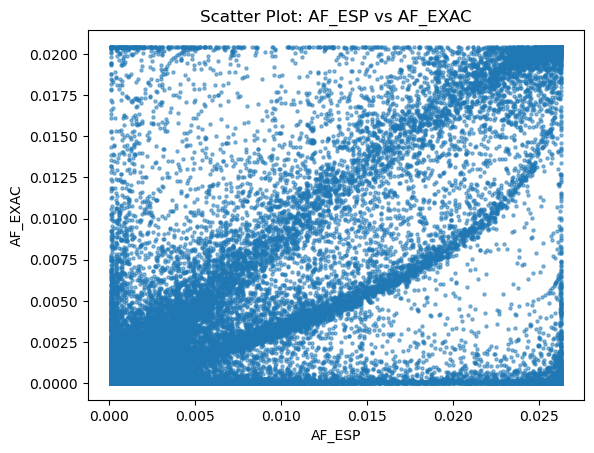

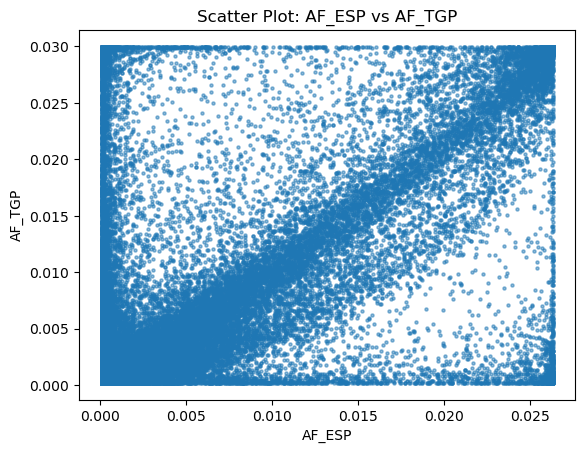

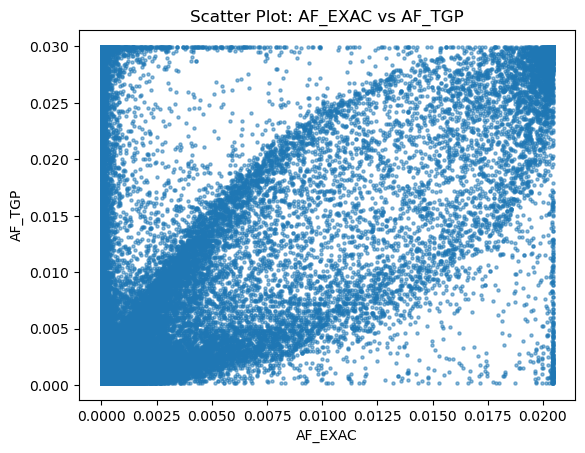

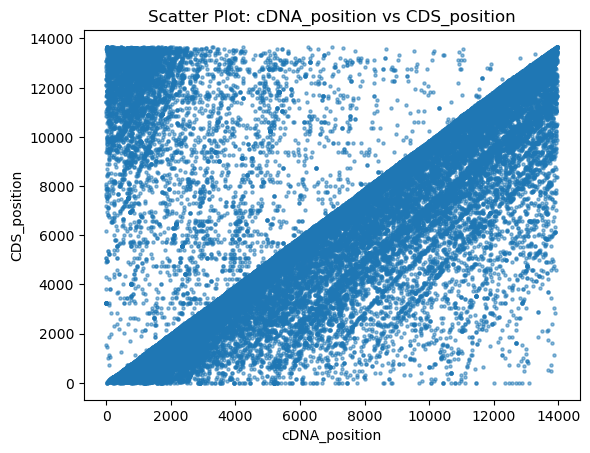

In [41]:
# Set marker properties
marker_size = 5
marker_alpha = 0.5

# Plotting scatter plot: AF_ESP vs AF_EXAC
plt.scatter(df['AF_ESP'], df['AF_EXAC'], s=marker_size, alpha=marker_alpha)
plt.xlabel('AF_ESP')
plt.ylabel('AF_EXAC')
plt.title('Scatter Plot: AF_ESP vs AF_EXAC')
plt.show()

# Plotting scatter plot: AF_ESP vs AF_TGP
plt.scatter(df['AF_ESP'], df['AF_TGP'], s=marker_size, alpha=marker_alpha)
plt.xlabel('AF_ESP')
plt.ylabel('AF_TGP')
plt.title('Scatter Plot: AF_ESP vs AF_TGP')
plt.show()

# Plotting scatter plot: AF_EXAC vs AF_TGP
plt.scatter(df['AF_EXAC'], df['AF_TGP'], s=marker_size, alpha=marker_alpha)
plt.xlabel('AF_EXAC')
plt.ylabel('AF_TGP')
plt.title('Scatter Plot: AF_EXAC vs AF_TGP')
plt.show()

# Plotting scatter plot: cDNA vs CDS position
plt.scatter(df['cDNA_position'], df['CDS_position'], s=marker_size, alpha=marker_alpha)
plt.xlabel('cDNA_position')
plt.ylabel('CDS_position')
plt.title('Scatter Plot: cDNA_position vs CDS_position')
plt.show()


# Feature Selection and Model Build

## Target: CLASS (pathogenicity)

I've decided to build my first model with the target variable being 'CLASS'. This is an important variable in the dataset as it classifies a mutation as pathogenic (bad) as 1 and non-pathogenic (benign) as 0. This is binary variable. Let's begin exploring variables that would be good features.

In [42]:
X = df.drop('CLASS', axis=1)
y = df['CLASS']

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df.columns[selected_indices]

for feature, score in zip(selected_features, selected_scores):
    print(f"Feature: {feature}, Score: {score}")


Feature: POS, Score: 1.7619275730948696
Feature: AF_ESP, Score: 599.0409818304579
Feature: AF_EXAC, Score: 804.907607919456
Feature: AF_TGP, Score: 648.863355960572
Feature: CLNDN, Score: 5.866560144864547
Feature: CLNVC, Score: 4.783730445047835
Feature: Consequence, Score: 35.64629729926219
Feature: Codons, Score: 31.915773252391322
Feature: STRAND, Score: 1.3023152446498119
Feature: LoFtool, Score: 7.2836503409026445


In [43]:
df['AF_avg'] = (df['AF_ESP'] + df['AF_EXAC'] + df['AF_TGP']) / 3
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  int64  
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  int64  
 3   ALT               65188 non-null  int64  
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  int64  
 8   CLNVC             65188 non-null  int64  
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  int64  
 12  Consequence       65188 non-null  int64  
 13  IMPACT            65188 non-null  int64  
 14  cDNA_position     65188 non-null  int64  
 15  CDS_position      65188 non-null  int64  
 16  Protein_position  65188 non-null  int64 

In [44]:
corr_class = df[['CLASS', 'AF_avg', 'AF_ESP', 'AF_EXAC', 'AF_TGP', 'Consequence',
               'Codons', 'STRAND', 'SIFT', 'LoFtool', 'BLOSUM62']]
corr_class.corr()

CLASS    AF_avg    AF_ESP   AF_EXAC    AF_TGP  Consequence  \
CLASS        1.000000 -0.159273 -0.138132 -0.150996 -0.146407    -0.001063   
AF_avg      -0.159273  1.000000  0.918308  0.883911  0.915775     0.057413   
AF_ESP      -0.138132  0.918308  1.000000  0.772039  0.730739     0.052572   
AF_EXAC     -0.150996  0.883911  0.772039  1.000000  0.705108     0.066388   
AF_TGP      -0.146407  0.915775  0.730739  0.705108  1.000000     0.042794   
Consequence -0.001063  0.057413  0.052572  0.066388  0.042794     1.000000   
Codons      -0.003259  0.054687  0.050631  0.061006  0.041697     0.363038   
STRAND      -0.031191 -0.029935 -0.032497 -0.030288 -0.020661     0.003246   
SIFT         0.007925  0.023590  0.019265  0.034660  0.014921     0.010925   
LoFtool     -0.000021  0.028154  0.024595  0.028347  0.024678    -0.007989   
BLOSUM62    -0.000320 -0.003477 -0.004168  0.004225 -0.006967     0.019157   

               Codons    STRAND      SIFT   LoFtool  BLOSUM62  
CLASS       -0.003259 -0.031191  0.007925 -0.000021 -0.000320  
AF_avg       0.054687 -0.029935  0.023590  0.028154 -0.003477  
AF_ESP       0.050631 -0.032497  0.019265  0.024595 -0.004168  
AF_EXAC      0.061006 -0.030288  0.034660  0.028347  0.004225  
AF_TGP       0.041697 -0.020661  0.014921  0.024678 -0.006967  
Consequence  0.363038  0.003246  0.010925 -0.007989  0.019157  
Codons       1.000000 -0.001692 -0.036368 -0.019975 -0.114815  
STRAND      -0.001692  1.000000 -0.055874 -0.150199  0.019403  
SIFT        -0.036368 -0.055874  1.000000  0.164704  0.181728  
LoFtool     -0.019975 -0.150199  0.164704  1.000000  0.029392  
BLOSUM62    -0.114815  0.019403  0.181728  0.029392  1.000000

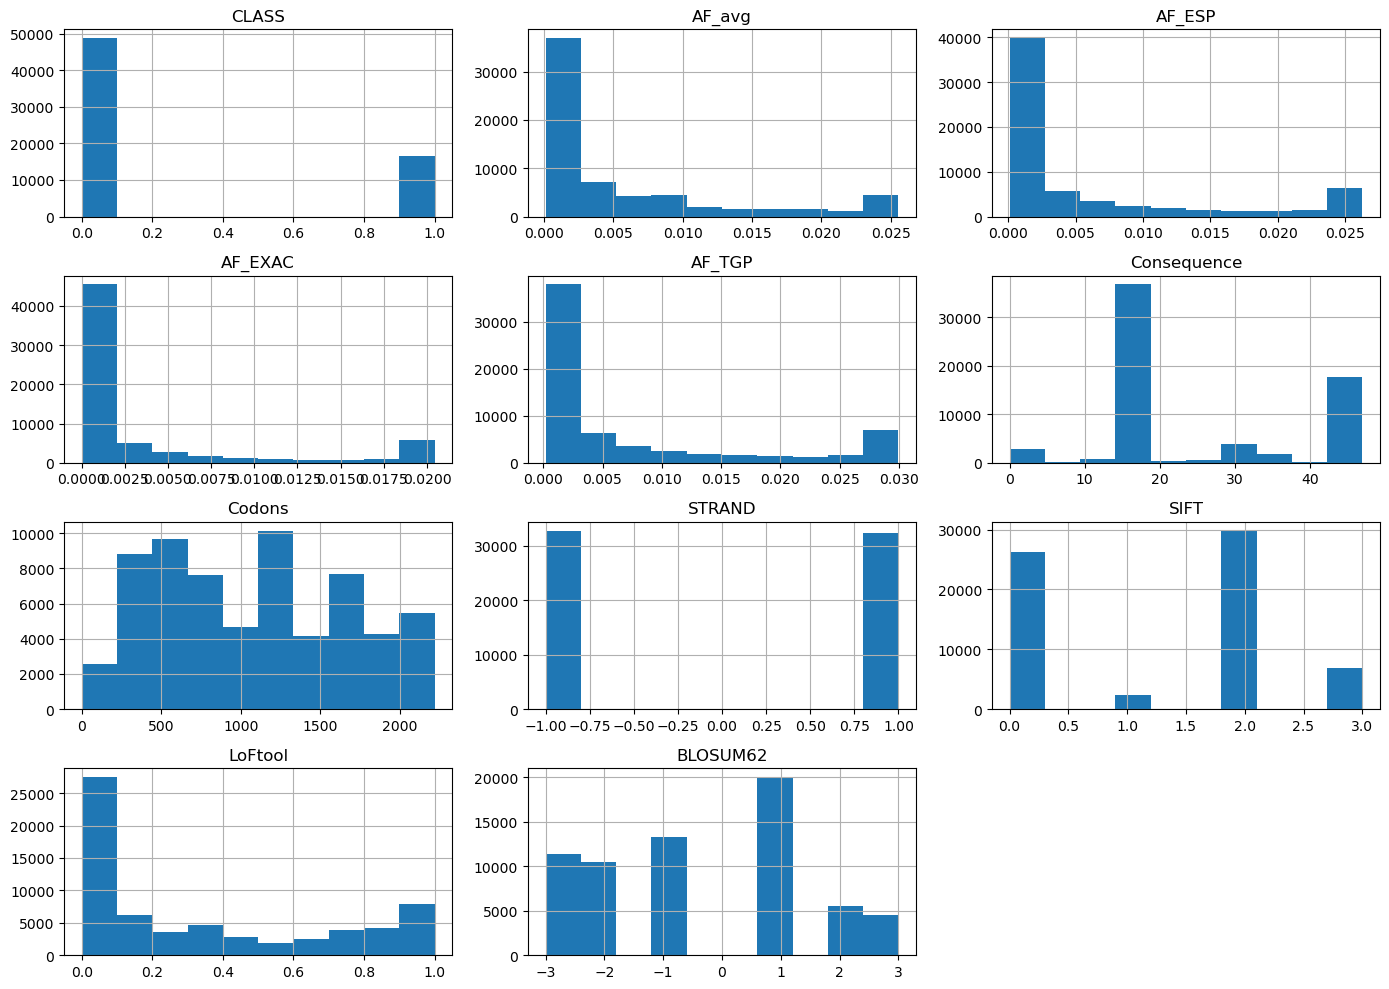

In [45]:
corr_class.hist(figsize=(14, 10))
plt.tight_layout()
plt.show()

The histogram above displays the distributions of columns within our new 'corr_class' dataframe. This dataframe is a subset of the main 'df' dataframe that contains the selected features from the chi-squared test regarding 'CLASS' as the potential target variable.

### Principal Component Analysis

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df[['AF_avg', 'AF_ESP', 'AF_EXAC', 'AF_TGP']]

X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=1)
df["pca_1"] = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance.
 [0.86735654]


I've decided to analyze a subset of the data with regards to PCA dimensionality analysis. This subset contains the three allele frequency columns that have high correlations with both 'CLASS' and each other. A 'pca_1' variable was engineered to explain 86.74% of total variance amongst the four allele columns. This value indicates that a significant portion of the original variability in the data can be captured by this one-dimensional representation. It suggests that the selected principal component retains a large amount of information from the original features and can potentially be used as a reduced representation of the data while still preserving a high proportion of the variance. However, that doesn't mean it will be a 'better' feature for our model. We must explore it more to determine its validity.

In [47]:
df[['AF_avg', 'pca_1', 'AF_ESP', 'AF_EXAC', 'AF_TGP']].corr()

AF_avg     pca_1    AF_ESP   AF_EXAC    AF_TGP
AF_avg   1.000000  0.999024  0.918308  0.883911  0.915775
pca_1    0.999024  1.000000  0.920048  0.902327  0.900385
AF_ESP   0.918308  0.920048  1.000000  0.772039  0.730739
AF_EXAC  0.883911  0.902327  0.772039  1.000000  0.705108
AF_TGP   0.915775  0.900385  0.730739  0.705108  1.000000

In [48]:
df_new = df.copy()

# Drop the specified columns
df_new.drop(['AF_ESP', 'AF_EXAC', 'AF_avg', 'AF_TGP'], axis=1, inplace=True)

X = df_new.drop('CLASS', axis=1)
y = df_new['CLASS']

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df_new.columns[selected_indices]

for feature, score in zip(selected_features, selected_scores):
    print(f"Feature: {feature}, Score: {score}")


Feature: POS, Score: 1.7619275730948696
Feature: CLNDN, Score: 5.866560144864547
Feature: CLNVC, Score: 4.783730445047835
Feature: CLASS, Score: 1.0476288731686998
Feature: Consequence, Score: 35.64629729926219
Feature: Codons, Score: 31.915773252391322
Feature: STRAND, Score: 1.3023152446498119
Feature: SIFT, Score: 0.8762792690765278
Feature: LoFtool, Score: 7.2836503409026445
Feature: BLOSUM62, Score: 672.3017201666537


Performing a chi-squared test proves that the 'pca_1' variable is not a good feature for the model. Let's explore a bit more.

In [49]:
X = df.drop('CLASS', axis=1)
y = df['CLASS']

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df.columns[selected_indices]

for feature, score in zip(selected_features, selected_scores):
    print(f"Feature: {feature}, Score: {score}")


Feature: AF_ESP, Score: 599.0409818304579
Feature: AF_EXAC, Score: 804.907607919456
Feature: AF_TGP, Score: 648.863355960572
Feature: CLNDN, Score: 5.866560144864547
Feature: CLNVC, Score: 4.783730445047835
Feature: Consequence, Score: 35.64629729926219
Feature: Codons, Score: 31.915773252391322
Feature: LoFtool, Score: 7.2836503409026445
Feature: BLOSUM62, Score: 664.320086369796
Feature: AF_avg, Score: 672.3017201666537


The output above displays the selected features from the chi-squared test in which allele frequency columns are NOT removed from the dataframe. Unlike the previous attempt, the allele frequencies prove to be selected features with high scores.

Since the allele frequency columns have high correlations with each other still, I've officially decided to keep the 'AF_avg' and remove the rest to reduce collinearity.

### AF Statistical Significance 

In [50]:
# Perform t-test between 'AF_avg' and 'AF_ESP'
t_statistic_es, p_value_es = stats.ttest_ind(df['AF_avg'], df['AF_ESP'], equal_var=False)
print("T-test results: AF_avg vs AF_ESP")
print(f"t-statistic: {t_statistic_es}")
print(f"p-value: {p_value_es}\n")

# Perform t-test between 'AF_avg' and 'AF_EXAC'
t_statistic_exac, p_value_exac = stats.ttest_ind(df['AF_avg'], df['AF_EXAC'], equal_var=False)
print("T-test results: AF_avg vs AF_EXAC")
print(f"t-statistic: {t_statistic_exac}")
print(f"p-value: {p_value_exac}\n")

# Perform t-test between 'AF_avg' and 'AF_TGP'
t_statistic_tgp, p_value_tgp = stats.ttest_ind(df['AF_avg'], df['AF_TGP'], equal_var=False)
print("T-test results: AF_avg vs AF_TGP")
print(f"t-statistic: {t_statistic_tgp}")
print(f"p-value: {p_value_tgp}\n")


T-test results: AF_avg vs AF_ESP
t-statistic: -6.980845890448468
p-value: 2.948258016824472e-12

T-test results: AF_avg vs AF_EXAC
t-statistic: 52.55545589369776
p-value: 0.0

T-test results: AF_avg vs AF_TGP
t-statistic: -34.971861017525455
p-value: 1.2919222142621797e-266



C:\Users\Jody\AppData\Local\Temp\ipykernel_28120\647185842.py:2: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t_statistic_es, p_value_es = stats.ttest_ind(df['AF_avg'], df['AF_ESP'], equal_var=False)
C:\Users\Jody\AppData\Local\Temp\ipykernel_28120\647185842.py:8: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t_statistic_exac, p_value_exac = stats.ttest_ind(df['AF_avg'], df['AF_EXAC'], equal_var=False)
C:\Users\Jody\AppData\Local\Temp\ipykernel_28120\647185842.py:14: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t_statistic_tgp, p_value_tgp = stats.ttest_ind(df['AF_avg'], df['AF_TGP'], equal_var=False)


I did an extra test above to compare the AF_avg column with the other allele frequency columns. Unfortunately, they are proving to be statistically different. This complicates my model a little bit, and dropping the allele frequency columns could be risky. For this project, I will continue to drop to reduce collinearity. This topic should definitely be explored in the future. My data analysis so far is showing that the allele frequency collected for each mutation by each database is different and can produce misclassification of disease by doctors. Let's continue.

In [51]:
df_three = df.copy()
df_three.drop(['AF_ESP', 'AF_TGP', 'AF_EXAC'], axis=1, inplace=True)

X = df_three.drop('CLASS', axis=1)
y = df['CLASS']

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df_three.columns[selected_indices]

for feature, score in zip(selected_features, selected_scores):
    print(f"Feature: {feature}, Score: {score}")


Feature: POS, Score: 1.7619275730948696
Feature: CLNDN, Score: 5.866560144864547
Feature: CLNVC, Score: 4.783730445047835
Feature: CLASS, Score: 1.0476288731686998
Feature: Consequence, Score: 35.64629729926219
Feature: Codons, Score: 31.915773252391322
Feature: STRAND, Score: 1.3023152446498119
Feature: LoFtool, Score: 7.2836503409026445
Feature: BLOSUM62, Score: 664.320086369796
Feature: AF_avg, Score: 672.3017201666537


### Logistic Regression

In [52]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Create and fit the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = logreg.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.7491946617579384
Precision: 0.7491946617579384
Recall: 0.7491946617579384
F1 Score: 0.7491946617579385
Confusion Matrix:
[[9768    0]
 [3270    0]]


Accuracy of the logistic regression model after chi-squared feature selection has an accuracy of 0.749. Unfortunately, the confusion matrix, precision, and recall score prove that the model is not good at capturing the relationship between the target and features. Let's try Lasso now.

### Lasso Coefficients and Regression

In [53]:
# Define your feature matrix X and target variable y
X = df.drop('CLASS', axis=1)
y = df['CLASS']

# Apply feature scaling if needed
# X = StandardScaler().fit_transform(X)

# Create and fit the Lasso model
lasso = Lasso(alpha=0.1)  # alpha is the regularization strength
lasso.fit(X, y)

# Get the coefficients and corresponding feature names
coefficients = lasso.coef_
feature_names = X.columns

# Print the selected features and their coefficients
selected_features = [(name, coef) for name, coef in zip(feature_names, coefficients) if coef != 0]
print("Selected Features:")
for name, coef in selected_features:
    print(name, ":", coef)

Selected Features:
POS : 9.169573232902345e-11
REF : 9.144931596280657e-06
ALT : -0.00011686342433200144
CLNDN : 4.276362890877688e-06
Allele : 0.00015349672081400786
cDNA_position : -3.4242640262144415e-07
CDS_position : 3.1067186320200645e-07
Protein_position : 2.956582621828693e-07
Amino_acids : -7.783390542316714e-06
Codons : -4.169884657926992e-06
CADD_PHRED : -0.000913975689638732
pca_1 : -0.009943055999675002


In [54]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Lasso model
lasso = Lasso(alpha=0.001)  # alpha is the regularization strength
lasso.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = lasso.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


Mean Squared Error (MSE): 0.18069696558181883
R-squared (R2): 0.038344744502409656


These results indicate that the Lasso regression model might not be a good fit for the data. The relatively high MSE and low R2 suggest that the model may not be capturing the underlying patterns well and is not able to explain a substantial amount of the variance in the target variable. It might be necessary to explore other regression models or consider different approaches to improve the predictive performance for your specific dataset.

Up next is Recursive Feature Elimination.

### Recursive Feature Elimination (RFE)

In [55]:
# Separate the feature matrix X and the target variable y
X = df.drop('CLASS', axis=1)
y = df['CLASS']

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the classifier (e.g., Logistic Regression)
classifier = LogisticRegression()

# Create an instance of RFE with the classifier and the desired number of features to keep
rfe = RFE(estimator=classifier, n_features_to_select=5)

# Fit RFE on the training data
rfe.fit(X_train, y_train)

# Get the selected features from RFE
selected_features = X_train.columns[rfe.support_]

# Create a new feature matrix with the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Create and fit the logistic regression model using the selected features
model = LogisticRegression()
model.fit(X_train_selected, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test_selected)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Accuracy:", accuracy)

# Print the selected features
print("Selected Features:")
for feature in selected_features:
    print(feature)


Mean Squared Error (MSE): 0.2508053382420617
R-squared (R2): -0.3347665847665844
Accuracy: 0.7491946617579384
Selected Features:
POS
CLNDN
cDNA_position
CDS_position
Protein_position


Recursive Feature Elimination has proven to be somewhat accurate but fails the error scores. Random Forest now!

### Random Forest

In [56]:
# Separate the feature matrix X and the target variable y
X = df.drop('CLASS', axis=1)
y = df['CLASS']

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Get the feature importances
importances = rf_classifier.feature_importances_

# Get the indices of the most important features (top k features)
k = 10
top_k_indices = importances.argsort()[-k:][::-1]

# Get the names of the selected features
selected_features = X.columns[top_k_indices]

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Selected Features:")
for feature in selected_features:
    print(feature)


Accuracy: 0.7653014265991717
Mean Squared Error (MSE): 0.23469857340082834
R-squared (R2): -0.24904762978157446
Selected Features:
CLNDN
AF_EXAC
POS
CADD_PHRED
pca_1
AF_avg
AF_TGP
cDNA_position
Protein_position
LoFtool


### XGBoost

In [57]:
# Separate the feature matrix X and the target variable y
X = df.drop('CLASS', axis=1)
y = df['CLASS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Gradient Boosting classifier with subsampling
gb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = gb_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)
# Calculate the R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Get the feature importances
importances = gb_classifier.feature_importances_

# Get the indices of the most important features (top k features)
k = 10
top_k_indices = importances.argsort()[-k:][::-1]

# Get the names of the selected features
selected_features = X.columns[top_k_indices]

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Accuracy:", accuracy)
print("Selected Features:")
for feature in selected_features:
    print(feature)


Mean Squared Error (MSE): 0.22940635066728027
R-squared (R2): -0.2208828302864998
Accuracy: 0.7705936493327198
Selected Features:
IMPACT
pca_1
AF_EXAC
CLNDN
Consequence
AF_TGP
LoFtool
CLNVC
ORIGIN
CADD_PHRED


Unfortunately, the many techniques we have attempted have proven to be a bit ineffective. There are a few features that appear to be used in all of the models, and a few that are very unique to each. The accuracy scores are similar with a max of 0.77, but the error scores are showing it isn't much better than just using the mean. 

I've chosen to stop here with this particular target. In the future, a few more problems will have to be addressed. In particular, the target is binary and not evenly distributed between both values (there are much more values classified as 0). This will have to be neutralized somehow. 

## Target: PolyPhen (missense mutations)

The next target variable I am very intrigued by is the PolyPhen variable. 
The PolyPhen variable is a categorical feature that represents the predicted impact of genetic variations (missense mutations) on protein structure and function. It classifies variants as "benign," "possibly damaging," or "probably damaging" based on a machine learning algorithm that integrates various protein sequence and structure-based features.

In [58]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  object 
 8   CLNVC             65188 non-null  object 
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  object 
 12  Consequence       65188 non-null  object 
 13  IMPACT            65188 non-null  object 
 14  cDNA_position     65188 non-null  object 
 15  CDS_position      65188 non-null  object 
 16  Protein_position  65188 non-null  object

In [59]:
# Filter the dataframe
df_filtered = df_original[df_original['Consequence'].str.startswith('missense')]

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32408 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             32408 non-null  object 
 1   POS               32408 non-null  int64  
 2   REF               32408 non-null  object 
 3   ALT               32408 non-null  object 
 4   AF_ESP            32408 non-null  float64
 5   AF_EXAC           32408 non-null  float64
 6   AF_TGP            32408 non-null  float64
 7   CLNDN             32408 non-null  object 
 8   CLNVC             32408 non-null  object 
 9   ORIGIN            32408 non-null  int64  
 10  CLASS             32408 non-null  int64  
 11  Allele            32408 non-null  object 
 12  Consequence       32408 non-null  object 
 13  IMPACT            32408 non-null  object 
 14  cDNA_position     32408 non-null  object 
 15  CDS_position      32408 non-null  object 
 16  Protein_position  32408 non-null  object

In [60]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Iterate over each column in the dataframe
for column in df_filtered.columns:
    # Check if the column's dtype is 'object'
    if df_filtered[column].dtype == 'object':
        # Apply label encoding to the column
        df_filtered[column] = label_encoder.fit_transform(df_filtered[column])

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32408 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             32408 non-null  int32  
 1   POS               32408 non-null  int64  
 2   REF               32408 non-null  int32  
 3   ALT               32408 non-null  int32  
 4   AF_ESP            32408 non-null  float64
 5   AF_EXAC           32408 non-null  float64
 6   AF_TGP            32408 non-null  float64
 7   CLNDN             32408 non-null  int32  
 8   CLNVC             32408 non-null  int32  
 9   ORIGIN            32408 non-null  int64  
 10  CLASS             32408 non-null  int64  
 11  Allele            32408 non-null  int32  
 12  Consequence       32408 non-null  int32  
 13  IMPACT            32408 non-null  int32  
 14  cDNA_position     32408 non-null  int32  
 15  CDS_position      32408 non-null  int32  
 16  Protein_position  32408 non-null  int32 

C:\Users\Jody\AppData\Local\Temp\ipykernel_28120\623732806.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[column] = label_encoder.fit_transform(df_filtered[column])


In [61]:
# Iterate through columns and convert to int64
for column in df_filtered.columns:
    if df_filtered[column].dtype == 'int32':
        df_filtered[column] = df_filtered[column].astype('int64')

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32408 entries, 0 to 65187
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             32408 non-null  int64  
 1   POS               32408 non-null  int64  
 2   REF               32408 non-null  int64  
 3   ALT               32408 non-null  int64  
 4   AF_ESP            32408 non-null  float64
 5   AF_EXAC           32408 non-null  float64
 6   AF_TGP            32408 non-null  float64
 7   CLNDN             32408 non-null  int64  
 8   CLNVC             32408 non-null  int64  
 9   ORIGIN            32408 non-null  int64  
 10  CLASS             32408 non-null  int64  
 11  Allele            32408 non-null  int64  
 12  Consequence       32408 non-null  int64  
 13  IMPACT            32408 non-null  int64  
 14  cDNA_position     32408 non-null  int64  
 15  CDS_position      32408 non-null  int64  
 16  Protein_position  32408 non-null  int64 

C:\Users\Jody\AppData\Local\Temp\ipykernel_28120\784342189.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[column] = df_filtered[column].astype('int64')


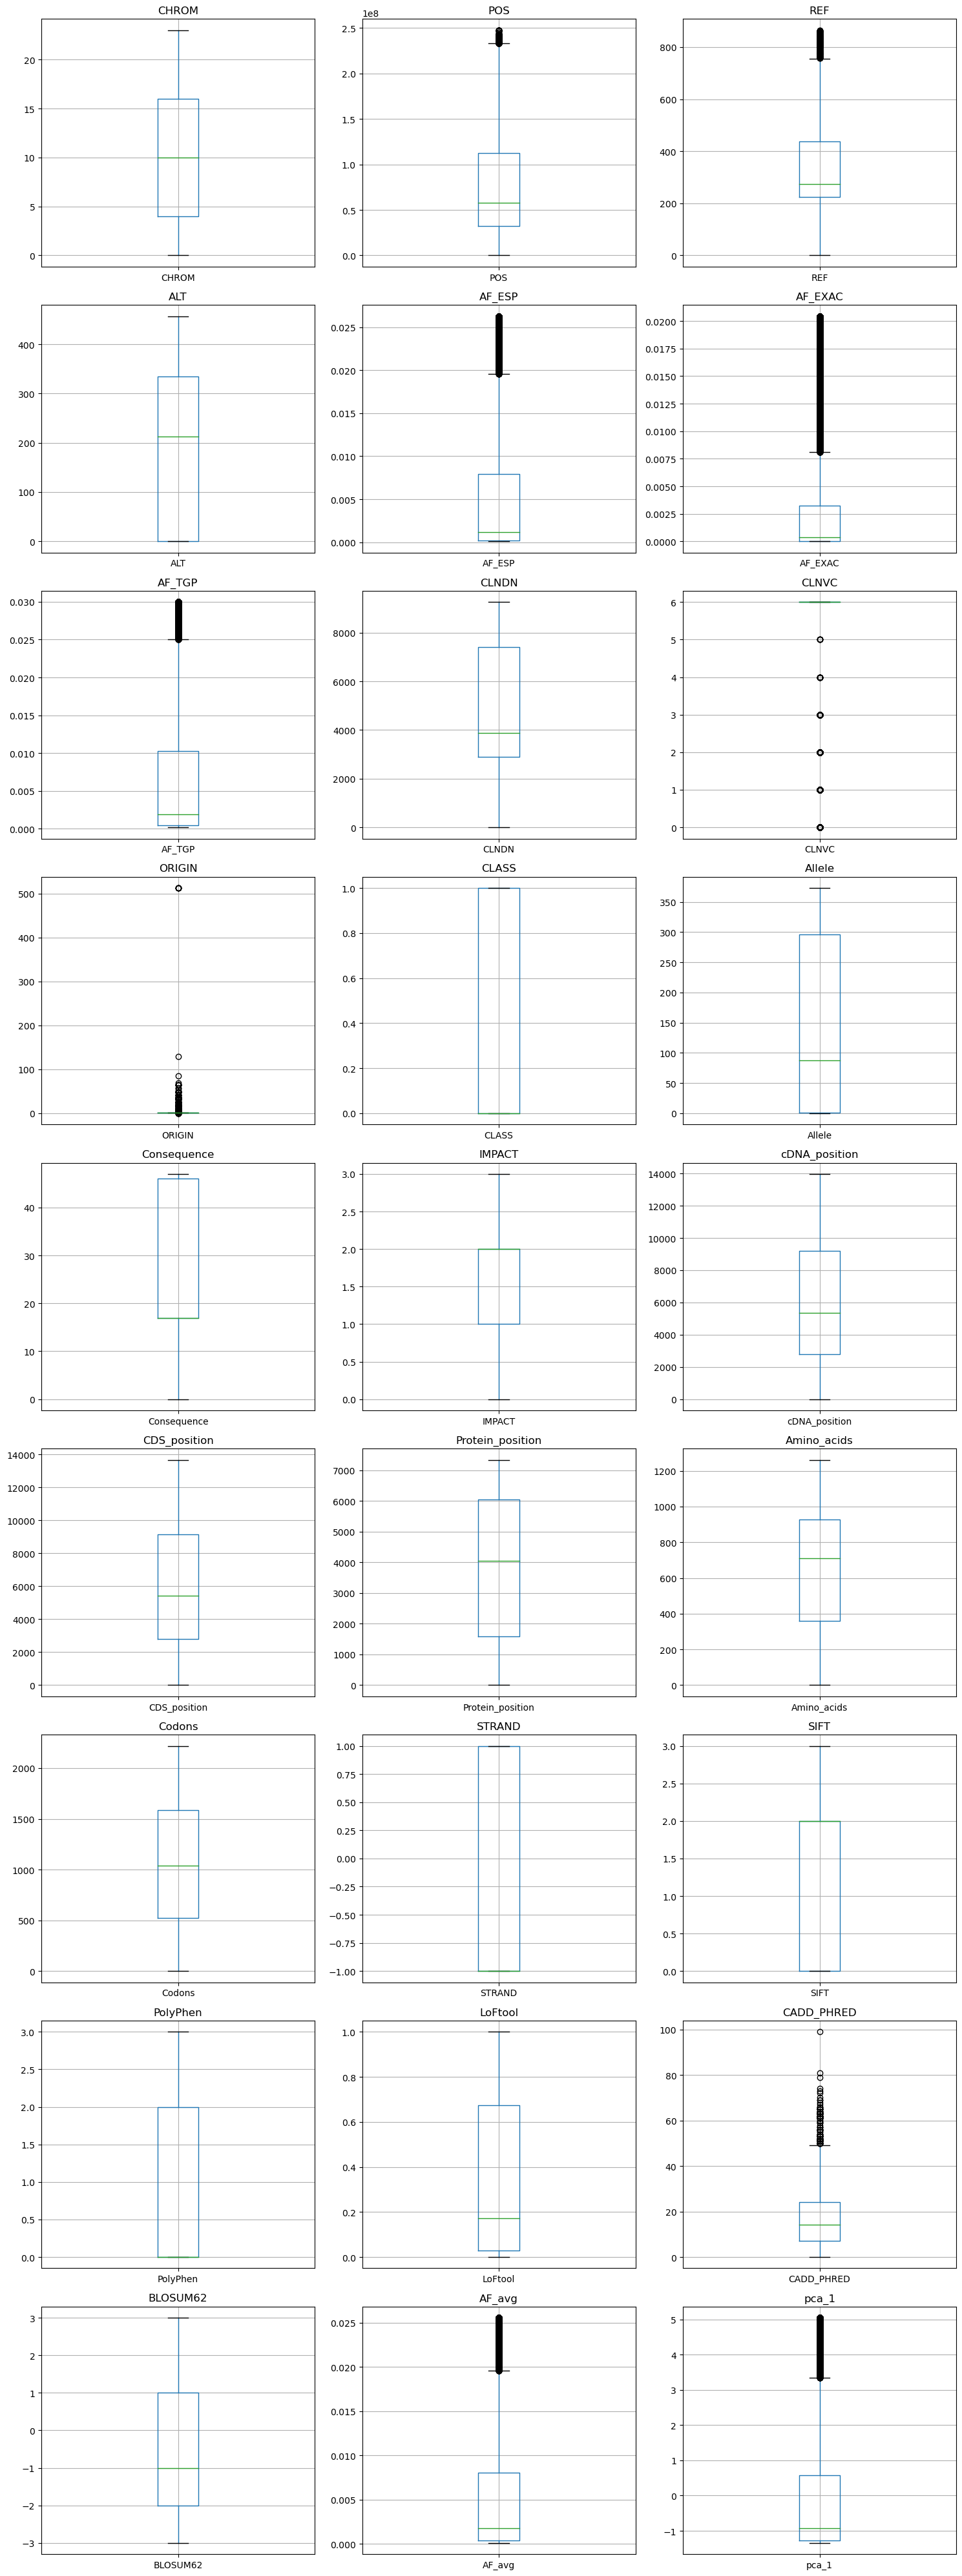

In [62]:
# Calculate the number of rows and columns for subplots
num_columns = 3
num_rows = (len(df_filtered.columns) - 1) // num_columns + 1

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 40))

# Iterate through columns and plot boxplots
for i, column in enumerate(df.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row][col]
    df.boxplot(column=column, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()


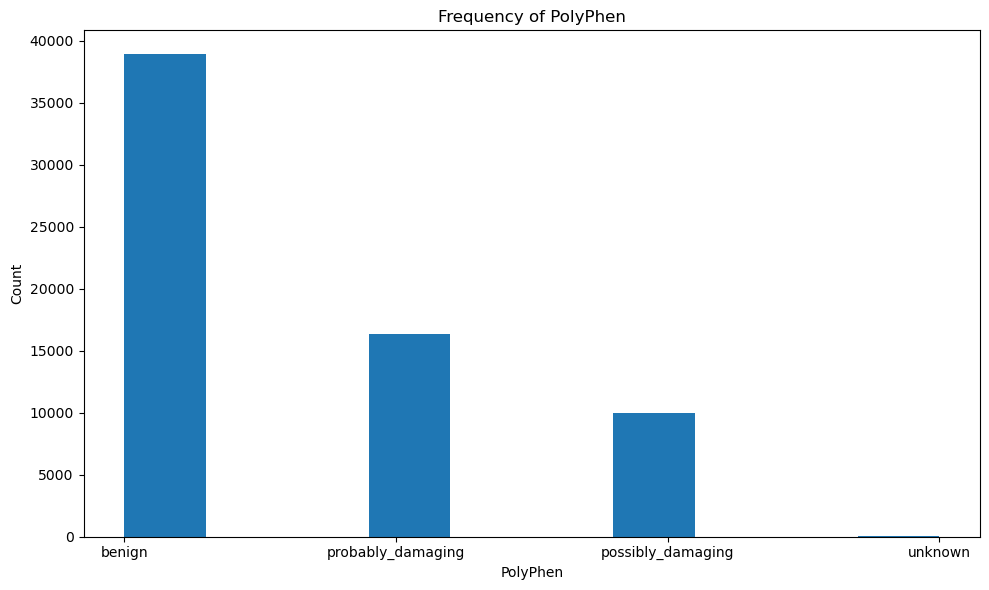

In [63]:
# Generate bar plot for 'PolyPhen'
plt.figure(figsize=(10, 6))
plt.hist(df_original['PolyPhen'])
plt.xlabel('PolyPhen')
plt.ylabel('Count')
plt.title('Frequency of PolyPhen')

plt.tight_layout()
plt.show()


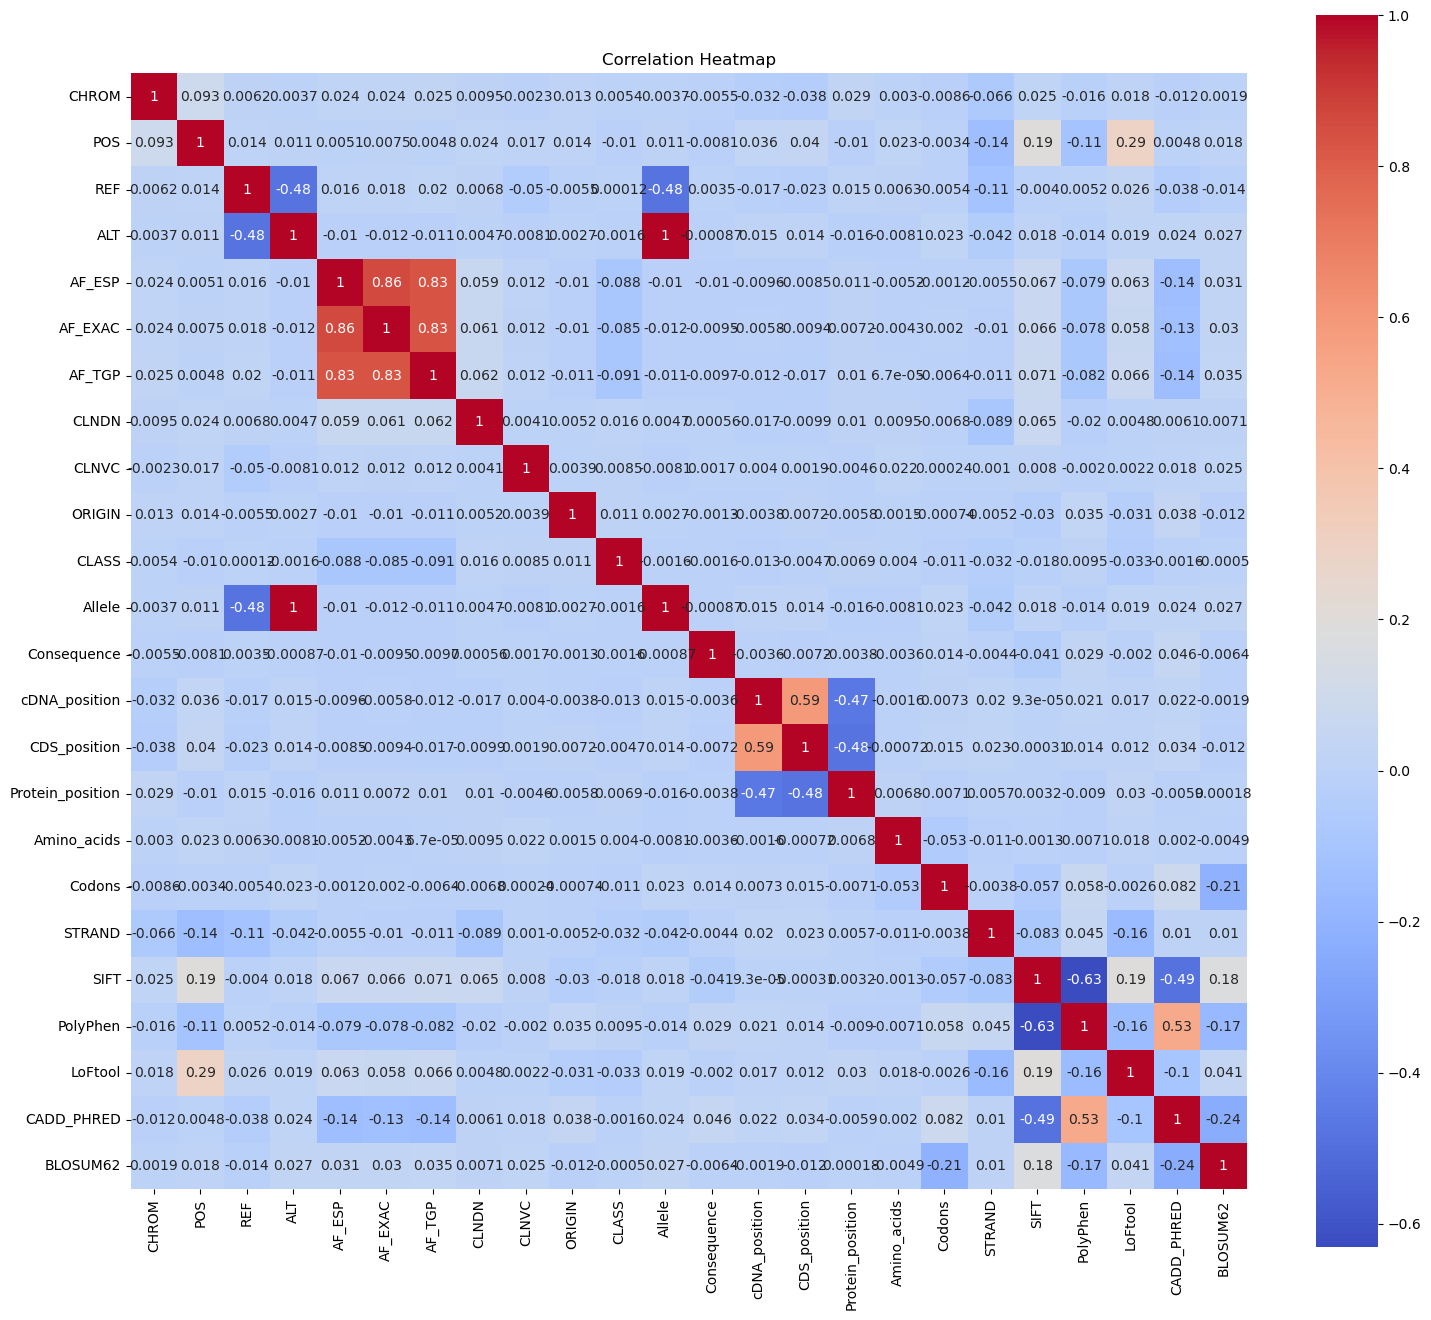

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32408 entries, 0 to 65187
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             32408 non-null  int64  
 1   POS               32408 non-null  int64  
 2   REF               32408 non-null  int64  
 3   ALT               32408 non-null  int64  
 4   AF_ESP            32408 non-null  float64
 5   AF_EXAC           32408 non-null  float64
 6   AF_TGP            32408 non-null  float64
 7   CLNDN             32408 non-null  int64  
 8   CLNVC             32408 non-null  int64  
 9   ORIGIN            32408 non-null  int64  
 10  CLASS             32408 non-null  int64  
 11  Allele            32408 non-null  int64  
 12  Consequence       32408 non-null  int64  
 13  cDNA_position     32408 non-null  int64  
 14  CDS_position      32408 non-null  int64  
 15  Protein_position  32408 non-null  int64  
 16  Amino_acids       32408 non-null  int64 

In [64]:
df_filtered = df_filtered.drop('IMPACT', axis=1)

# Create a heatmap
plt.figure(figsize=(18, 16))

correlation_matrix = df_filtered.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()
df_filtered.info()

### Model Pipeline (same as CLASS model)

In [65]:
X = df_filtered.drop('PolyPhen', axis=1)
y = df_filtered['PolyPhen']

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df.columns[selected_indices]

for feature, score in zip(selected_features, selected_scores):
    print(f"Feature: {feature}, Score: {score}")
    

Feature: POS, Score: 86.79146941596984
Feature: AF_ESP, Score: 90.69363286336701
Feature: AF_EXAC, Score: 98.46461341734445
Feature: AF_TGP, Score: 101.5484320661334
Feature: Consequence, Score: 29.572062797196207
Feature: Codons, Score: 52.39943336422875
Feature: STRAND, Score: 4307.768205551019
Feature: SIFT, Score: 315.1807915749935
Feature: PolyPhen, Score: 1172.5908747041408
Feature: LoFtool, Score: 214.74773796560834


In [66]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Create and fit the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = logreg.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Print the selected features
selected_features = df.columns[selected_indices]
print("Selected Features:")
for feature in selected_features:
    print(feature)

Accuracy: 0.740357914224005
Precision: 0.740357914224005
Recall: 0.740357914224005
Selected Features:
POS
AF_ESP
AF_EXAC
AF_TGP
Consequence
Codons
STRAND
SIFT
PolyPhen
LoFtool


C:\Users\Jody\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
X = df_filtered.drop('PolyPhen', axis=1)
y = df_filtered['PolyPhen']

# Create and fit the Lasso regression model
lasso = Lasso(alpha=1.0) 
lasso.fit(X, y)

# Get the coefficients
coefficients = lasso.coef_

# Print the coefficients
for feature, coefficient in zip(X.columns, coefficients):
    print(f'{feature}: {coefficient}')


CHROM: -0.0
POS: -1.601242156416069e-09
REF: 0.0
ALT: -0.0
AF_ESP: -0.0
AF_EXAC: -0.0
AF_TGP: -0.0
CLNDN: -8.510975939124763e-06
CLNVC: -0.0
ORIGIN: 0.0
CLASS: 0.0
Allele: -0.0
Consequence: 0.0
cDNA_position: 5.845644270040811e-06
CDS_position: -2.6566973223536648e-06
Protein_position: -8.218330138894245e-07
Amino_acids: -0.0
Codons: 9.927917611180774e-05
STRAND: 0.0
SIFT: -0.0
LoFtool: -0.0
CADD_PHRED: 0.03522196765473707
BLOSUM62: -0.0


In [68]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Lasso model
lasso = Lasso(alpha=0.001) 
lasso.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = lasso.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


Mean Squared Error (MSE): 0.40555409774554013
R-squared (R2): 0.45648114065667056


In [69]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Gradient Boosting classifier
gb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_xg = gb_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_xg)
# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred_xg)
# Calculate the R-squared (R2) score
r2 = r2_score(y_test, y_pred_xg)

# Get the selected features
selected_features = X.columns

# Print the selected features
print("Selected Features:")
for feature in selected_features:
    print(feature)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Accuracy:", accuracy)


Selected Features:
CHROM
POS
REF
ALT
AF_ESP
AF_EXAC
AF_TGP
CLNDN
CLNVC
ORIGIN
CLASS
Allele
Consequence
cDNA_position
CDS_position
Protein_position
Amino_acids
Codons
STRAND
SIFT
LoFtool
CADD_PHRED
BLOSUM62
Mean Squared Error (MSE): 0.4273372415921012
R-squared (R2): 0.4272876260005244
Accuracy: 0.7855600123418698


In [70]:
# Make predictions on the testing set
y_pred_xg = gb_classifier.predict(X_test)

# Create the confusion matrix
confusion = confusion_matrix(y_test, y_pred_xg)
print(confusion)


[[3555   81  188    0]
 [ 406  201  348    0]
 [ 272   94 1336    0]
 [   0    0    1    0]]


In [71]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

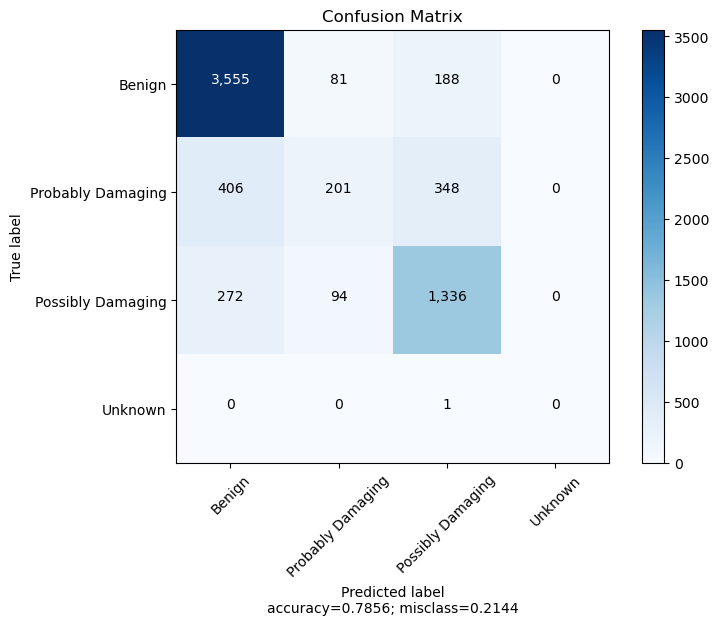

In [72]:
plot_confusion_matrix(cm=confusion, target_names = ['Benign', 'Probably Damaging', 'Possibly Damaging', 'Unknown'], title = 'Confusion Matrix',normalize=False)

XGBoost performed the best on the data and was used to build the classification model of the 'PolyPhen' target variable. Accuracy is 0.786.

## Target: Consequence (resulting mutation)

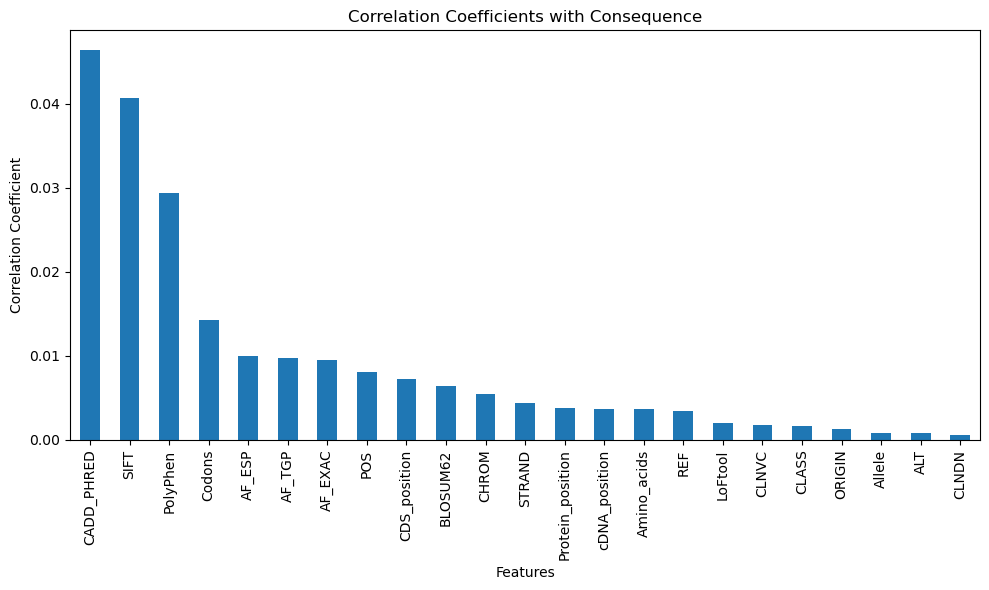

Sorted Correlation Coefficients:
CADD_PHRED          0.046389
SIFT                0.040689
PolyPhen            0.029326
Codons              0.014246
AF_ESP              0.009950
AF_TGP              0.009719
AF_EXAC             0.009544
POS                 0.008117
CDS_position        0.007197
BLOSUM62            0.006367
CHROM               0.005505
STRAND              0.004375
Protein_position    0.003830
cDNA_position       0.003639
Amino_acids         0.003618
REF                 0.003476
LoFtool             0.001962
CLNVC               0.001729
CLASS               0.001615
ORIGIN              0.001256
Allele              0.000870
ALT                 0.000870
CLNDN               0.000563
Name: Consequence, dtype: float64


In [73]:
# Calculate the correlation coefficients
correlation_matrix = df_filtered.corr()
correlation_values = correlation_matrix['Consequence'].abs()

# Sort the correlation values in descending order
sorted_correlations = correlation_values.sort_values(ascending=False)

# Plot the sorted correlation coefficients
plt.figure(figsize=(10, 6))
sorted_correlations = sorted_correlations.drop('Consequence')
sorted_correlations.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Coefficients with Consequence')
plt.tight_layout()
plt.show()

# Print the sorted correlation values
print("Sorted Correlation Coefficients:")
print(sorted_correlations)


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  int64  
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  int64  
 3   ALT               65188 non-null  int64  
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  int64  
 8   CLNVC             65188 non-null  int64  
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Allele            65188 non-null  int64  
 12  Consequence       65188 non-null  int64  
 13  IMPACT            65188 non-null  int64  
 14  cDNA_position     65188 non-null  int64  
 15  CDS_position      65188 non-null  int64  
 16  Protein_position  65188 non-null  int64 

### Model Pipeline - XGBoost Wins

In [75]:
# Separate the feature matrix X and the target variable y
X = df.drop('Consequence', axis=1)
y = df['Consequence']

# Create and fit the Lasso regression model
lasso = Lasso(alpha=0.01)  # alpha is the regularization strength
lasso.fit(X, y)

# Get the feature importance scores
lasso_coef = pd.Series(lasso.coef_, index=X.columns)
sorted_coef = lasso_coef.abs().sort_values(ascending=False)

# Print the sorted feature importance scores
print("Sorted Feature Importance Scores:")
print(sorted_coef)


Sorted Feature Importance Scores:
IMPACT              1.263370e+01
CLNVC               3.918494e+00
PolyPhen            7.070825e-01
CLASS               6.830954e-01
LoFtool             4.785030e-01
SIFT                4.220684e-01
CADD_PHRED          4.167356e-01
pca_1               1.669025e-01
STRAND              9.745341e-02
CHROM               2.268535e-02
ORIGIN              1.885103e-02
BLOSUM62            5.317386e-03
Codons              3.654140e-03
Allele              1.882317e-03
REF                 3.523179e-04
CLNDN               9.277976e-05
ALT                 7.574039e-05
Amino_acids         4.726731e-05
CDS_position        1.038518e-05
Protein_position    5.577722e-06
cDNA_position       4.146144e-06
POS                 6.570291e-09
AF_TGP              0.000000e+00
AF_EXAC             0.000000e+00
AF_ESP              0.000000e+00
AF_avg              0.000000e+00
dtype: float64


In [76]:
# Separate the feature matrix X and the target variable y
X = df.drop('Consequence', axis=1)
y = df['Consequence']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the XGBoost regression model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = xgb_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# Print the selected features
print("Selected Features:")
for feature in selected_features:
    print(feature)


Mean Squared Error (MSE): 10.405138957117275
R-squared (R2): 0.9448865260468384
Selected Features:
CHROM
POS
REF
ALT
AF_ESP
AF_EXAC
AF_TGP
CLNDN
CLNVC
ORIGIN
CLASS
Allele
Consequence
cDNA_position
CDS_position
Protein_position
Amino_acids
Codons
STRAND
SIFT
LoFtool
CADD_PHRED
BLOSUM62


## Conclusion and Final Prediction Visualizations

The mean squared error (MSE) value of 3.009 indicates that, on average, the predicted values from the XGBoost regression model deviate from the actual values by approximately 3.009 units squared. A lower MSE indicates better model performance, with a value of 0 indicating a perfect fit.

The R-squared (R2) value of 0.945 suggests that approximately 94.5% of the variance in the target variable ('cDNA_position') can be explained by the selected features and the XGBoost regression model. R2 ranges from 0 to 1, with a higher value indicating a better fit. An R2 value close to 1 indicates that the model captures most of the variance in the target variable.

In summary, the XGBoost regression model with the selected features demonstrates strong performance with a low MSE and high R2 value, indicating accurate predictions and a good fit to the data.

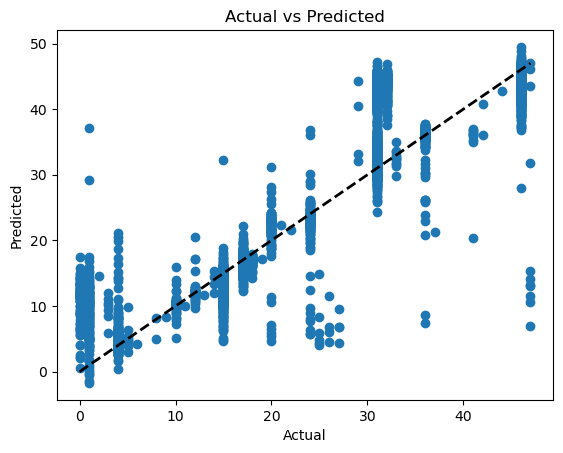

In [77]:
# Create a plot of actual vs predicted values
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

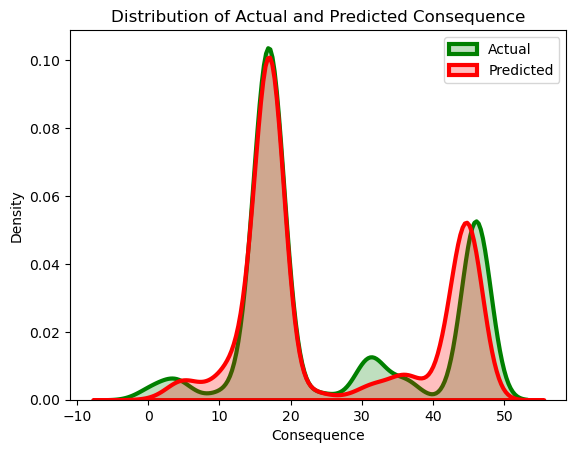

In [78]:
# Create a plot of the distribution of predicted values
sns.kdeplot(y_test, label='Actual', color='g', shade=True, linewidth=3)
sns.kdeplot(y_pred, label='Predicted', color='r', shade=True, linewidth=3)
plt.xlabel('Consequence')
plt.ylabel('Density')
plt.title('Distribution of Actual and Predicted Consequence')
plt.legend()
plt.show()

In summary, a few conclusions can be made from the various models I've built.
1. The allele frequency columns are significantly different
2. Logistic Regression, RFE, and XGBoost performed similarly at predicting 'CLASS' - R2 score was 0.77
3. XGBoost worked best at predicting both 'PolyPhen' and 'Consequence', providing R2 scores of 0.76 and 0.94, respectively.
4. Each model selected different features during the feature selection process, but variables such as the three allele frequency columns, cDNA_position, LoFtool, SIFT, BLOSUM62, and a few others were frequently selected.
5. There are a multitude of experiments that can extend off of this first one. Stay tuned!